In [3]:
# Importing the necessary libraries
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

# This was installed programatically as it was not in the environment   
#%pip install jsonpath-ng

#%pip install nltk
#%pip install nlp
#!pip install --upgrade nltk

# import scikit-learn
import sklearn

import json
from jsonpath_ng import parse


# import nltk

import nltk
#nltk.download('all')
from nltk.tokenize import word_tokenize




In [4]:

# Read contents of XLSX file in to a pandas dataframe      

df_ISBN = pd.read_excel("/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3\MA5851_SP82_2023_A1_Data.xlsx", sheet_name='ISBN_Data')
df_Subjects = pd.read_excel("/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3\MA5851_SP82_2023_A1_Data.xlsx", sheet_name='Subjects')


Now that we have the Raw data ingested in to data frames, lets check to see if there is cleani8ng required, ie duplicate ISBNs missing data etc

In [5]:
#check if there are any missing values in the ISBN dataframe        
df_ISBN.isnull().sum()


School_ID    0
State        0
Year         0
Subject      0
ISBN         0
dtype: int64

Check for duplicate keys (ISBN) to see if it's worth reducing the API calls for enrichment.

In [6]:

# print summary of df_ISBN
print(df_ISBN.info())
print()
# identify duplicate ISBNs in the df_IDBN dataframe and print them and their counts
print(df_ISBN[df_ISBN.duplicated(subset=['ISBN'], keep=False)].groupby('ISBN').size())
# how many unique ISBNs are there in the df_ISBN dataframe
print(df_ISBN['ISBN'].nunique())
# how many rows are there in the df_ISBN dataframe
print(df_ISBN.shape[0])
# how many duplicate ISBNs are there in the df_ISBN dataframe
print(df_ISBN.shape[0]-df_ISBN['ISBN'].nunique())





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   School_ID  1804 non-null   int64 
 1   State      1804 non-null   object
 2   Year       1804 non-null   int64 
 3   Subject    1804 non-null   object
 4   ISBN       1804 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 70.6+ KB
None

ISBN
9780007485505    2
9780008141639    2
9780008241384    3
9780008359850    2
9780008377380    3
                ..
9788409171965    2
9789401705288    3
9789620435904    2
9789620435942    2
9798708474995    8
Length: 384, dtype: int64
1071
1804
733


Because there are so many, it would be wasteful to call the APIs multiple times for the same ISBN, therefore will get a unique list of ISBNs to enrich via APIs, check the unique df looks ok.

In [7]:
# extract unique ISBNs from the df_ISBN dataframe
df_ISBN_unique = df_ISBN.drop_duplicates(subset=['ISBN'], keep='first')
#keep only the ISBN column
df_ISBN_unique = df_ISBN_unique[['ISBN']]

# print the number of unique ISBNs
print("Number of unique ISBNs in the data :"+str(df_ISBN_unique.shape[0]))
print()
df_ISBN_unique.head(2)


Number of unique ISBNs in the data :1071



,ISBN
0,9781741250879
1,9780648237327



Setting up constants and functions that will be used when enriching the provided book dataset with two APIs (Trove and Google Books) 

From visual inspection of the API spec, the following enrichments should be applied to the data

From trove:  issued,type,hasCorrections,subjects
From google: title, authors,publisher,maturityRating,printType,pageCount,language,country,isEbook,saleability,textSnippet,categories,description


The following is used to enrich the provided datasets from the Trove and Google book APIs

In [9]:
# set URls, Keys and query templates for trove and google book APIs 

TROVE_API_KEY='REDACTED'    # Should not be checked in to git.  will consider using environment variables instead, or a config file
TROVE_URL="http://api.trove.nla.gov.au/v2/result"
GOOGLE_URL="https://www.googleapis.com/books/v1/volumes"
#set up query parameters for trove API and goodle book API
tparams = {'key': TROVE_API_KEY, 'zone': 'book', 'q': 'isbn:', 'encoding': 'json', 'n': '1'}
gparams = {'q': 'isbn:'}


# These are the enrichments from Trove that we want to extract
fromTrove={'issued': 'response.zone[0].records.work[0].issued',  
           'type': 'response.zone[0].records.work[0].type', 
           'hasCorrections': 'response.zone[0].records.work[0].hasCorrections', 
           'hasReprints': 'response.zone[0].records.work[0].hasReprints', 
           'hasReviews': 'response.zone[0].records.work[0].hasReviews', 
           'hasTranslations': 'response.zone[0].records.work[0].hasTranslations', 
           'hasVersions': 'response.zone[0].records.work[0].hasVersions', 
           'subjects': 'response.zone[0].records.work[0].subjects'}

#These are the enrichments from Google that we want to extract
fromGoogle={'title': 'items[0].volumeInfo.title',
            "authors": 'items[0].volumeInfo.authors',
            "publisher": 'items[0].volumeInfo.publisher',  
            "description": 'items[0].volumeInfo.description', 
            "pageCount": 'items[0].volumeInfo.pageCount',
            "categories": 'items[0].volumeInfo.categories',
            "averageRating": 'items[0].volumeInfo.averageRating', 
            "ratingsCount": 'items[0].volumeInfo.ratingsCount',
            "maturityRating": 'items[0].volumeInfo.maturityRating',
            "language": 'items[0].volumeInfo.language',
            "printType": 'items[0].volumeInfo.printType',
            "country": 'items[0].saleInfo.country',
            "isEbook": 'items[0].saleInfo.isEbook',
            "saleability": 'items[0].saleInfo.saleability',
            "textSnippet": 'items[0].searchInfo.textSnippet',
            "categories": 'items[0].volumeInfo.categories'}


# create a json string containing the enrichment data for the current ISBN
# noting when a value is missing in the API response, an "N/A" will be set instead
def constructEnrichedResult(tresponse,gresponse,result):
        # set the results of queries to the two APIs to variables
        tbook = tresponse.json(); gbook = gresponse.json()
        #result["isbn"]=isbn
        # Get the trove enrichment and populate the result dict
        for key in fromTrove:
            try:
                result[key] = [match.value for match in parse(fromTrove[key]).find(tbook)][0]
            except:
                result[key] = "N/A"
        # Get the google enrichment and populate the result dict
        for key in fromGoogle:
            try:
                result[key] = [match.value for match in parse(fromGoogle[key]).find(gbook)][0]
            except:
                result[key] = "N/A" 
        return result


# Call the two APIs and return the enrichment data for the current ISBN
def search_book(isbn):
        # Note slight difference in query string for trove and google
        tparams.update({'q': 'isbn:"'+isbn+'"'})
        gparams.update({'q': 'isbn:'+isbn+''})
        result={}
        try:
                tresponse = requests.get(TROVE_URL, params=tparams)
                gresponse = requests.get(GOOGLE_URL, params=gparams)
                # There is reasonable overlap between the two APIs but here we are using the best data
                result=constructEnrichedResult(tresponse,gresponse,result)
        except:
                print("Provlem enriching data for ISBN: "+isbn)
                result["isbn"]=isbn
        return(result)


Now creating an enrichment JSON document by iterrating through the df_ISBN_unique dataframe. The resulting enrichment JSON will be used to augment the full dataset with the extra data from the APIs. This minimises API calls.

In [10]:
# copy the original df_ISBN dataframe to a new dataframe
df_enrichedUniqueBooks=df_ISBN_unique.copy()

# itterate through rows in df_ISBN_unnique and add the enrichment data to the df_enrichedBooks dataframe
for index, row in df_enrichedUniqueBooks.iterrows():
        result=search_book(str(row['ISBN']))
        # add columns to df_enrichedUniqueBooks       
        # itterate through the keys in the result dict and add the values to the df_enrichedUniqueBooks dataframe
        for key in result:
                df_enrichedUniqueBooks.loc[index,key]=str(result[key])


# print the enriched dataframe, to confirm processing was successful  
df_enrichedUniqueBooks.head(2)



,ISBN,issued,type,hasCorrections,hasReprints,hasReviews,hasTranslations,hasVersions,subjects,title,...,categories,averageRating,ratingsCount,maturityRating,language,printType,country,isEbook,saleability,textSnippet
0,9781741250879,2003-2004,"['Book/Illustrated', 'Book']",N,N/A,N/A,N/A,N/A,N/A,Victorian Targeting Handwriting,...,['Penmanship'],N/A,N/A,NOT_MATURE,en,BOOK,AU,False,NOT_FOR_SALE,This series supplies teachers with a comprehen...
1,9780648237327,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Kluwell My Home Reading Yellow Level,...,N/A,N/A,N/A,NOT_MATURE,en,BOOK,AU,False,NOT_FOR_SALE,Suitable for lower primary students.


The following merges the original df_ISBN data with df_enrichedUniqueBook data to create a new dataset where the original data (with duplicates) is enriched.  The left join by ISBN is made.

In [11]:
# merge the enriched data with the original data, left join (ie all rows from the original data will be included)
df_enrichedBooks = pd.merge(df_ISBN, df_enrichedUniqueBooks, on='ISBN', how='left')
# save df_enrichedBooks to a new excel file
df_enrichedBooks.to_excel("/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3\MA5851_SP82_2023_A1_Data_Enriched.xlsx", sheet_name='ISBN_Data', index=False)

df_enrichedBooks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804 entries, 0 to 1803
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   School_ID        1804 non-null   int64 
 1   State            1804 non-null   object
 2   Year             1804 non-null   int64 
 3   Subject          1804 non-null   object
 4   ISBN             1804 non-null   int64 
 5   issued           1804 non-null   object
 6   type             1804 non-null   object
 7   hasCorrections   1804 non-null   object
 8   hasReprints      1804 non-null   object
 9   hasReviews       1804 non-null   object
 10  hasTranslations  1804 non-null   object
 11  hasVersions      1804 non-null   object
 12  subjects         1804 non-null   object
 13  title            1804 non-null   object
 14  authors          1804 non-null   object
 15  publisher        1804 non-null   object
 16  description      1804 non-null   object
 17  pageCount        1804 non-null   

Explore the enriched data, to understand subjects, schools, year, types. catagories .... so that we can determine the values and how to vectorise, 

Maybe we can identify clusters of similar consumers School, State Year, Subject

Number of rows with missing descriptions: 705
Number of rows with missing descriptions and missing text snippets: 552
Columns in df_enrichedBooks: Index(['School_ID', 'State', 'Year', 'Subject', 'ISBN', 'issued', 'type',
       'hasCorrections', 'hasReprints', 'hasReviews', 'hasTranslations',
       'hasVersions', 'subjects', 'title', 'authors', 'publisher',
       'description', 'pageCount', 'categories', 'averageRating',
       'ratingsCount', 'maturityRating', 'language', 'printType', 'country',
       'isEbook', 'saleability', 'textSnippet'],
      dtype='object')


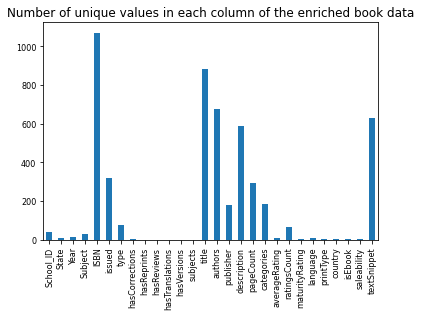


Number of unique subjects in the data: 30
Number of unique subjects in the subject list: 30
Subjects in the data that are not in the subject list just to a check: []


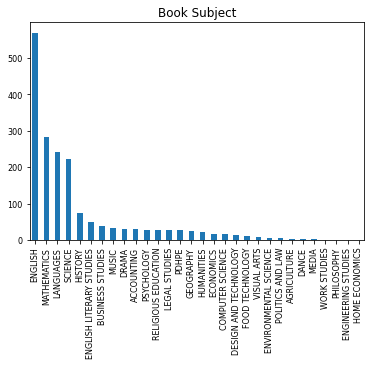

In [12]:
# How many rows of df_enrichedBookshave missing descriptions?
print("Number of rows with missing descriptions: "+str(df_enrichedBooks[df_enrichedBooks['description']=='N/A'].shape[0]))
# How many rows of df_enrichedBookshave missing descriptions and missing text snippets?
print("Number of rows with missing descriptions and missing text snippets: "+str(df_enrichedBooks[(df_enrichedBooks['description']=='N/A') & (df_enrichedBooks['textSnippet']=='N/A')].shape[0]))

# make all df_enrichedBooks Subject column values upper case (found one was lower in original dataset).
df_enrichedBooks['Subject'] = df_enrichedBooks['Subject'].str.upper()


# Print the names of the columns in df_enrichedBooks
print("Columns in df_enrichedBooks: "+str(df_enrichedBooks.columns))

# plot of columns in df_enrichedBooks vs the number of unique values in each column to see where the data has been enriched
df_enrichedBooks.nunique().plot(kind='bar', title='Number of unique values in each column of the enriched book data', fontsize=8)
plt.show()

# Print the number of Unique Subjects in df_enrichedBooks   
print("\nNumber of unique subjects in the data: "+str(df_enrichedBooks['Subject'].nunique()))
#Printthe number of unioque Subnjects in df_Subjects
print("Number of unique subjects in the subject list: "+str(df_Subjects['Subjects'].nunique()))
#are there any Subjects in df_enrichedBooks that are not in df_Subjects?
print("Subjects in the data that are not in the subject list just to a check: "+str(df_enrichedBooks[~df_enrichedBooks['Subject'].isin(df_Subjects['Subjects'])]['Subject'].unique()))

df_enrichedBooks['Subject'].value_counts().plot(kind='bar', title='Book Subject', fontsize=8)
plt.show()




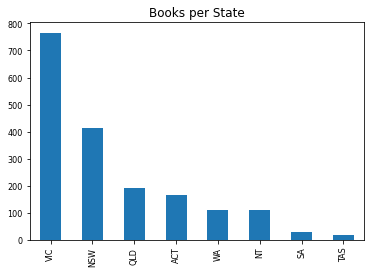

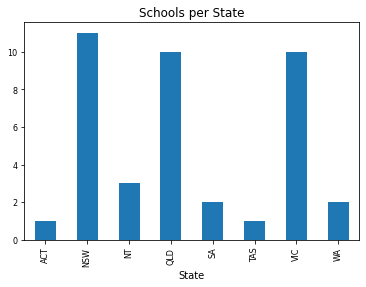

In [13]:
# plot bumber of books per state
df_enrichedBooks['State'].value_counts().plot(kind='bar', title='Books per State', fontsize=8)
plt.show()

# plot number of schools per state
df_enrichedBooks.groupby('State')['School_ID'].nunique().plot(kind='bar', title='Schools per State', fontsize=8)
plt.show()

# plot the total number of books by type
#df_enrichedBooks['type'].value_counts().plot(kind='bar', title='Books by Type', fontsize=8)


Number of non-English or Unknown language books: 235
Number of rows with unknown language: 185
Number of non-English language books: 50
Non-English language book languages: ['ar' 'un' 'ja' 'de' 'el' 'fr' 'zh-CN' 'es']

All languages in data: ['en' 'ar' 'un' 'ja' 'de' 'el' 'fr' 'zh-CN' 'es']


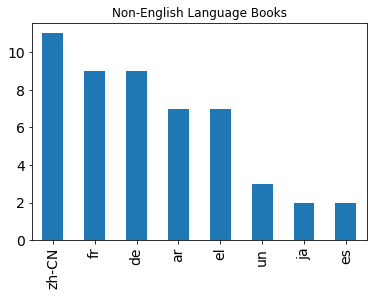

In [14]:
#are there any ISBNs in df_enrichedBooks that do not have "en" language column?
print("\nNumber of non-English or Unknown language books: "+str(df_enrichedBooks[~df_enrichedBooks['language'].isin(['en'])].shape[0]))
#are there any ISBNs in df_enrichedBooks that have "N/A" in the language column?
print("Number of rows with unknown language: "+str(df_enrichedBooks[df_enrichedBooks['language'].isin(['N/A'])].shape[0]))
#are there any ISBNs in df_enrichedBooks that do not have "en" or "N/A" in the language column?
print("Number of non-English language books: "+str(df_enrichedBooks[~df_enrichedBooks['language'].isin(['en','N/A'])].shape[0]))
# print the language for ny ISBNs in df_enrichedBooks that do not have "en" or "N/A" in the language column
print("Non-English language book languages: "+str(df_enrichedBooks[~df_enrichedBooks['language'].isin(['en','N/A'])]['language'].unique()))

df_enrichedBooks[~df_enrichedBooks['language'].isin(['en','N/A'])]['language'].value_counts().plot(kind='bar', title='Non-English Language Books',fontsize=14)

# create a language list without N/A
languageList=df_enrichedBooks[~df_enrichedBooks['language'].isin(['N/A'])]['language'].unique()
print("\nAll languages in data: "+str(languageList))



plt.show()




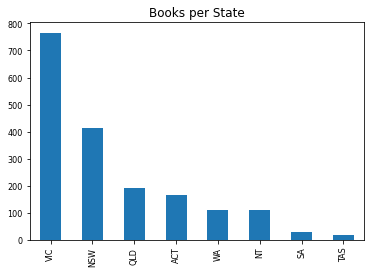

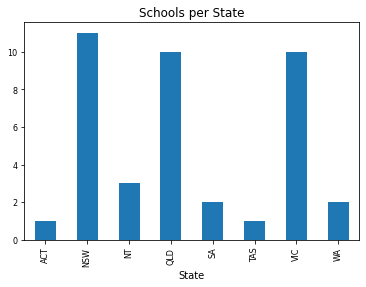

In [15]:
# plot bumber of books per state
df_enrichedBooks['State'].value_counts().plot(kind='bar', title='Books per State', fontsize=8)
plt.show()

# plot number of schools per state
df_enrichedBooks.groupby('State')['School_ID'].nunique().plot(kind='bar', title='Schools per State', fontsize=8)
plt.show()


Explore book types


Number of book types in the data: 24
Book types in the data: dict_keys(['Book/Illustrated', 'Book', 'Audio book', 'Book/Braille', 'Sound', 'Sound/Other sound', 'Map', 'Map/Atlas', 'Book/Large print', 'Article/Book chapter', 'Government publication', 'Microform', 'Periodical', 'Periodical/Journal, magazine, other', 'Video', 'Article/Working paper', 'Sound/Recorded music', 'Conference Proceedings', 'Thesis', 'Article/Review', 'Article/Journal or magazine article', 'Article', 'Article/Report', 'Published'])


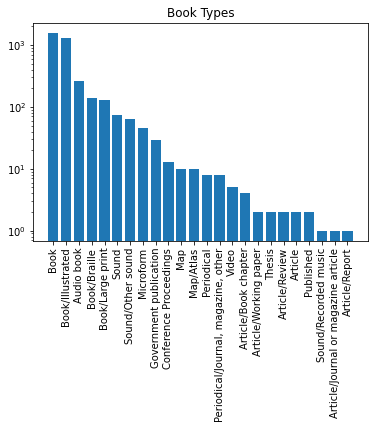

In [16]:


# A function to plot the keys verses values in a dictionary
def plotDict(dict,title,log):
    # sort dict keys by the values
    dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1], reverse=True)}
    plt.bar(range(len(dict)), list(dict.values()), align='center')
    plt.xticks(range(len(dict)), list(dict.keys()), rotation=90)
    if log:
        plt.yscale('log')
    plt.title(title)
    plt.show()  

# Explore the book types in the data
# for each row in df_enrichedBooks extract the type value
typeDict={}
for index, row in df_enrichedBooks.iterrows():
    typeValue=df_enrichedBooks.loc[index,'type']
    if typeValue != 'N/A':
        #print(typeValue)
        # convert the typeValue  string to a list
        typeList = eval(typeValue)
        # itterate through the typeList and add each type to a dictionary
        for type in typeList:
            if type not in typeDict:
                typeDict[type]=1
            else:
                typeDict[type]+=1


print("\nNumber of book types in the data: "+str(len(typeDict)))
print("Book types in the data: "+str(typeDict.keys()))
# plot the values in the typeDict dictionary
plotDict(typeDict,"Book Types", True)  # Log scale on y axis

Now we'll identify any data from enrichment that will not go forward to create featured. This is when there were no values obtained from APIs or where there are too few values to justify adding the dimenciopn to a feature frame.   


Columns with all N/A values: ['hasReprints', 'hasReviews', 'hasTranslations', 'hasVersions', 'subjects']

Columns with only two values, one of which is N/A: ['hasCorrections', 'printType', 'country']

Columns with all the same value: ['hasReprints', 'hasReviews', 'hasTranslations', 'hasVersions', 'subjects']


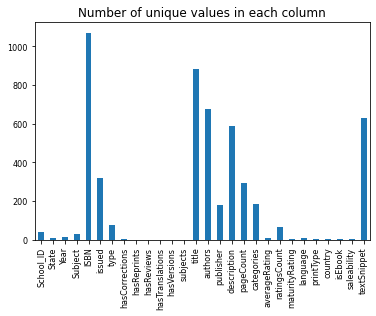

In [17]:

#Identify de_EnrichedBooks columns where all values are "N/A"
print("\nColumns with all N/A values: "+str(df_enrichedBooks.columns[df_enrichedBooks.isin(['N/A']).all()].tolist()))

#Identify de_EnrichedBooks columns where there are only two different values, where one in "N/A"
print("\nColumns with only two values, one of which is N/A: "+str(df_enrichedBooks.columns[df_enrichedBooks.nunique()==2].tolist()))
print("\nColumns with all the same value: "+str(df_enrichedBooks.columns[df_enrichedBooks.nunique()==1].tolist()))


# plot of columns in df_enrichedBooks vs the number of unique values in each column
df_enrichedBooks.nunique().plot(kind='bar', title='Number of unique values in each column', fontsize=8)
plt.show()


Checking in to the Authors column
Want to know how many inique names are there, if too many will not include in the feture frame.

It may be possible to segment the authors by popularity for specific years and use this in the feature frame ..  leaving this for now as it may not be worth the effort.


Number of unique authors in the data: 1257
First 10 authors in the data: ['Jane Pinsker', ' Tricia Dearborn', ' Jo Ryan', ' Stephen Michael King', ' Susan Young', 'Stan Kluzek', ' Andrew Coldwell', 'Mem Fox', 'Mary Serenc', ' Lena Ford', ' Chris Linthorne', 'Katy Pike', 'N/A', 'Alan Davies', 'Jane Pinsker', 'Mary Serenc', 'ORIGO Education', 'Davina McClure', ' Ruth Friend', 'Firefly Education', ' Mary Serenc', ' Jane Rheeder', ' Carolyn Smales', ' Wayne Lightbourne', 'Curriculum Associates Staff', 'McGraw Hill', 'Deborah Adcock', ' Stephen Davies', 'Jane Pinsker', ' Tricia Dearborn', ' Jo Ryan', ' Stephen Michael King', 'Annette Smith', 'Harry OBrien', ' Greg Purcell', 'Lesley Ljungdahl', ' Maree Williams', 'Cliff Derkson', ' R.I.C.Publications Staff', 'Mary Serenc', ' Chris Linthorne', ' Lena Ford', 'Mary Serence', 'Oxford Atlas', 'Lauren OBrien', 'Gail Nightingale', ' Paul Nightingale', 'Peter Durkin', ' Heather Sperring', ' Virginia Ferguson', 'Lesley Ljungdahl', 'Alan Davies', ' D

c:\Users\stkotlya\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



Number of popular authors in the data: 10

Number of regular authors in the data: 53

Number of authors in the authorsDict dictionary: 1066


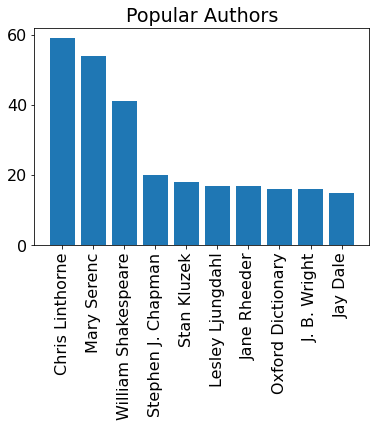

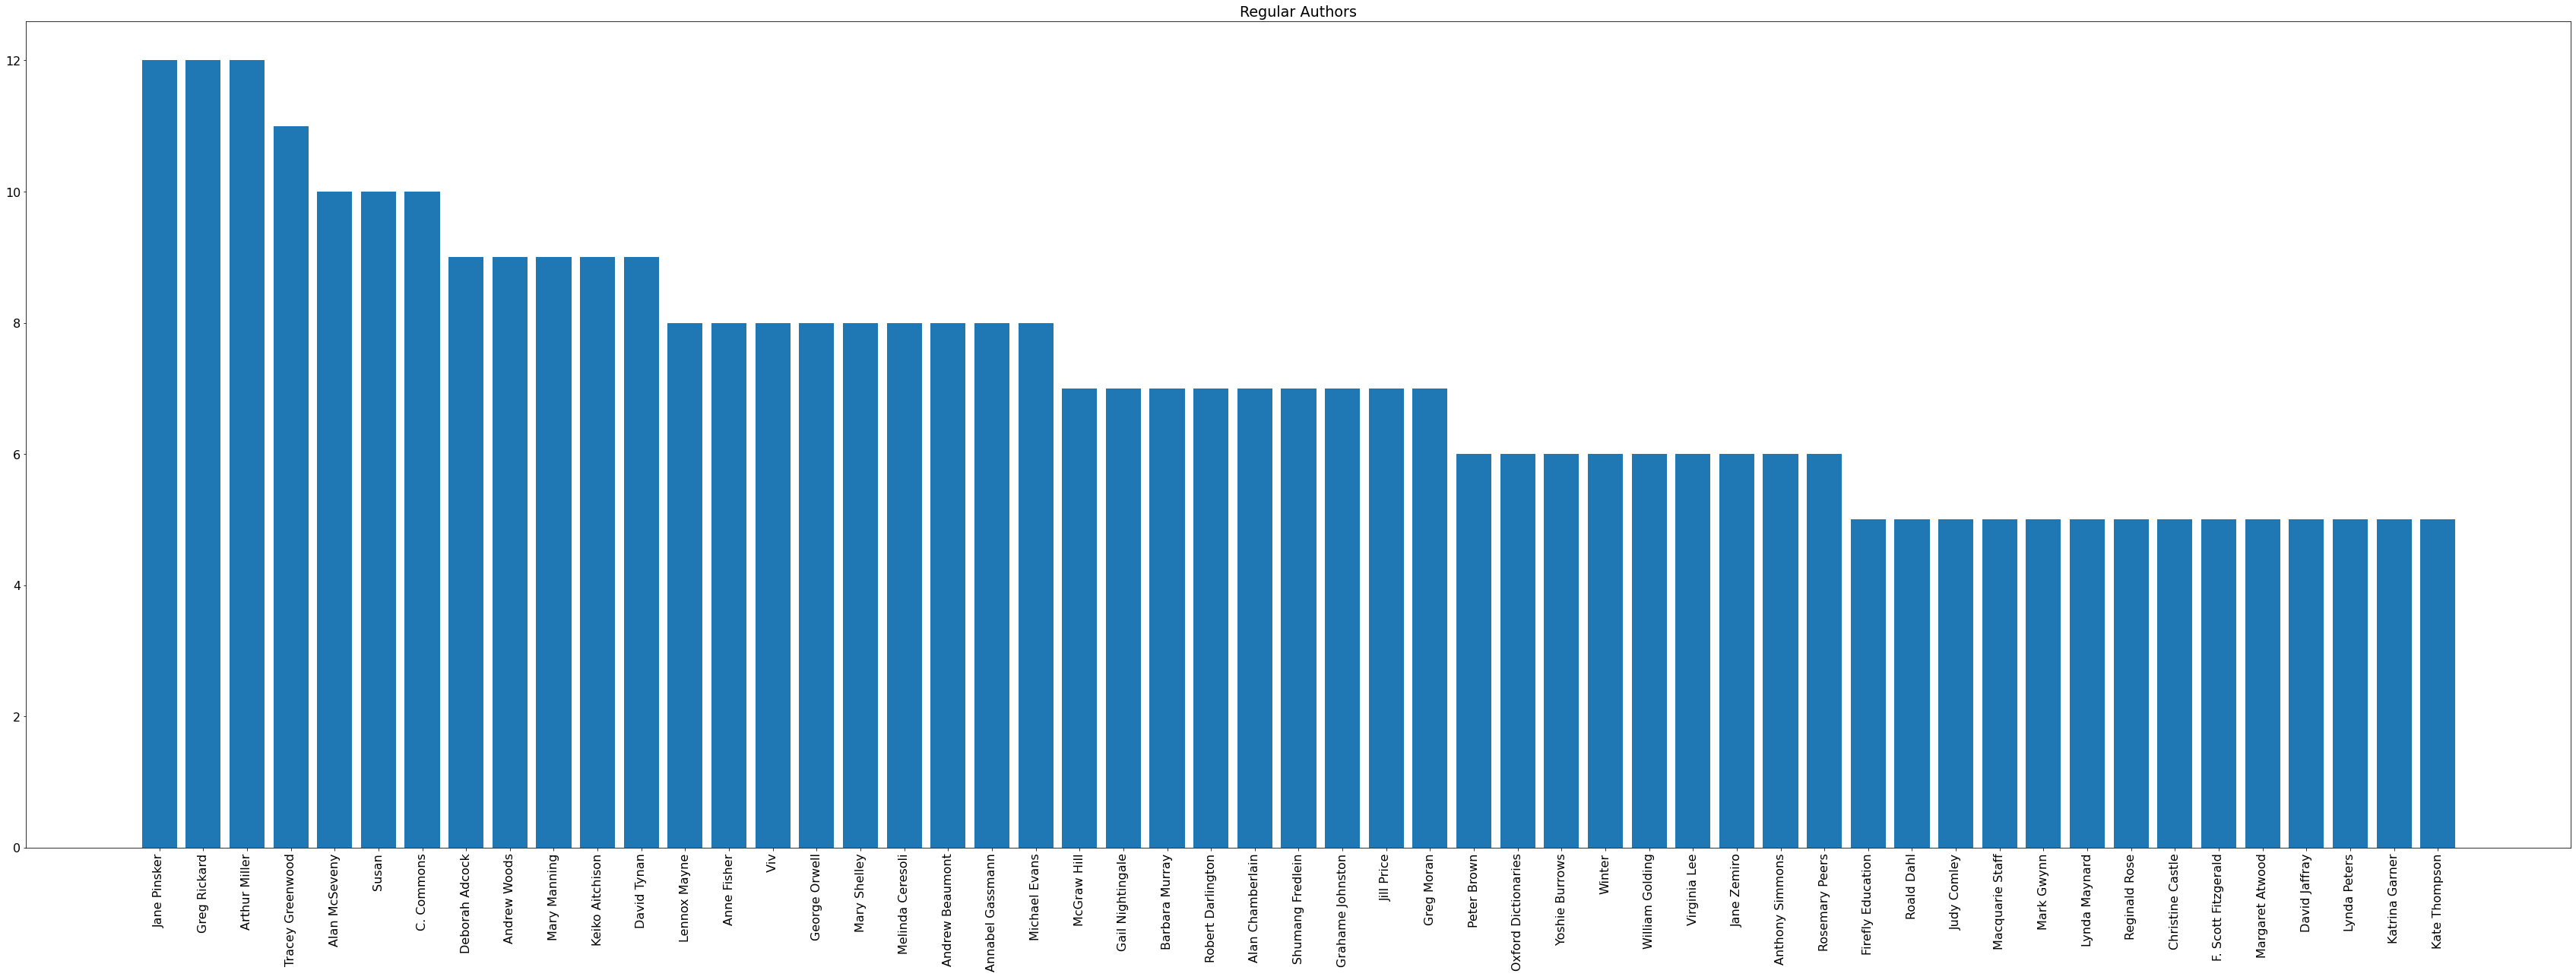

In [18]:
# extract the unique values in the authors column
authorsList=df_enrichedBooks['authors'].unique()
# replace the square brackets, commas and double quotes 
authorsList = [x.replace('[','').replace(']','').replace("'","").replace('"','') for x in authorsList]
# split the authorsList into a list of lists
authorsList = [x.split(',') for x in authorsList]
# flatten the list of lists
authorsList = [item for sublist in authorsList for item in sublist]

print("\nNumber of unique authors in the data: "+str(len(authorsList)))
# print the first 10 authors in the authorsList
print("First 10 authors in the data: "+str(authorsList[0:100]))

# remove authorsList entries that are empty strings or "N/A"
authorsList = [x for x in authorsList if x != '']
authorsList = [x for x in authorsList if x != 'N/A']
# remove authorsList entries that are clearly not Authors that I could see in the data, like "Collins" and "Dictionary"
authorsList = [x for x in authorsList if x != 'Collins']
authorsList = [x for x in authorsList if x != 'Dictionary']
authorsList = [x for x in authorsList if x != 'Collins Dictionaries']
authorsList = [x for x in authorsList if x != 'HarperCollins Publishers']
authorsList = [x for x in authorsList if x != 'Oxford Atlas']



#how many times does an author appear in the data
# foreach author in the authorsList count the number of times they appear in df_enrichedBooks authors column
authorsDict={}
for author in authorsList:
    authorsDict[author]=df_enrichedBooks[df_enrichedBooks['authors'].str.contains(author)].shape[0]

# copy the authorsDict dictionary to popularAuthorsDict
popularAuthorsDict=authorsDict.copy()
popularAuthorsDict={k: v for k, v in popularAuthorsDict.items() if v >= 15}
print("\nNumber of popular authors in the data: "+str(len(popularAuthorsDict)))

# copy the authorsDict dictionary to regularAuthorsDict
regularAuthorsDict=authorsDict.copy()
regularAuthorsDict={k: v for k, v in regularAuthorsDict.items() if (v < 15 and v >= 5)}
print("\nNumber of regular authors in the data: "+str(len(regularAuthorsDict)))


print("\nNumber of authors in the authorsDict dictionary: "+str(len(authorsDict)))

# sort the authorsDict dictionary by the values
authorsDict = {k: v for k, v in sorted(authorsDict.items(), key=lambda item: item[1], reverse=True)}
# print the first 10 authors in the authorsDict dictionary
#print("\nFirst 10 authors in the authorsDict dictionary: "+str(list(authorsDict.items())[0:10]))

# plot the values in the popularAuthorDict and regularAuthorDict dictionaries
plt.rcParams.update({'font.size': 16})
plotDict(popularAuthorsDict,"Popular Authors", False)  # Liniear scale on y axis
fig, axs = plt.subplots(figsize=(60, 20))  # Bigger plot
plotDict(regularAuthorsDict,"Regular Authors", False)  # Liniear scale on y axis


# create list of popular authors
popularAuthorsList=list(popularAuthorsDict.keys())
# create list of regular authors
regularAuthorsList=list(regularAuthorsDict.keys())







According to the problem statement publisher data is likely to be an important feature, since schools have an incentive to order from the same publisher. Below we will derive the common publishers that will go forward to a feature frame.

{'N/A': 1129, 'Omnibus Books': 1, 'Blake Publishing': 1, 'Zondervan': 1, 'McGraw-Hill Education': 21, 'Nightingale Press': 2, 'R.I.C. Publications': 3, 'Willy the Chimp': 1, 'Penguin': 7, 'Pascal Press': 19, 'IQRA International Educational Foun': 3, 'PUFFIN BOOKS': 1, 'Candlewick': 1, 'Springer': 4, 'Thomas Nelson': 3, 'Penguin Random House Australia': 1, 'Papaloizos Pub: Greek123': 3, 'London : Jonathan Cape': 2, 'Puffin Books': 1, 'Viking Books for Young Readers': 2, 'HarperCollins Australia': 3, 'Serenity Press Pty.Limited': 2, 'Prentice Hall': 6, 'HarperCollins': 2, 'Viking': 1, 'Puffin HC': 4, 'Little, Brown Books for Young Readers': 2, 'National Geographic Books': 41, "HarperCollins Children's Books": 1, 'Putnam Juvenile': 1, 'HarperOne': 3, 'Univ. of Queensland Press': 2, 'Allen & Unwin': 2, 'OUP Oxford': 7, 'Random House Australia': 2, 'Penguin Classics': 10, '5m Books Ltd': 1, 'Cambridge University Press': 75, 'Rigby': 1, 'Nelson Thornes': 1, 'Starscape': 1, 'Vintage': 10, 'Al

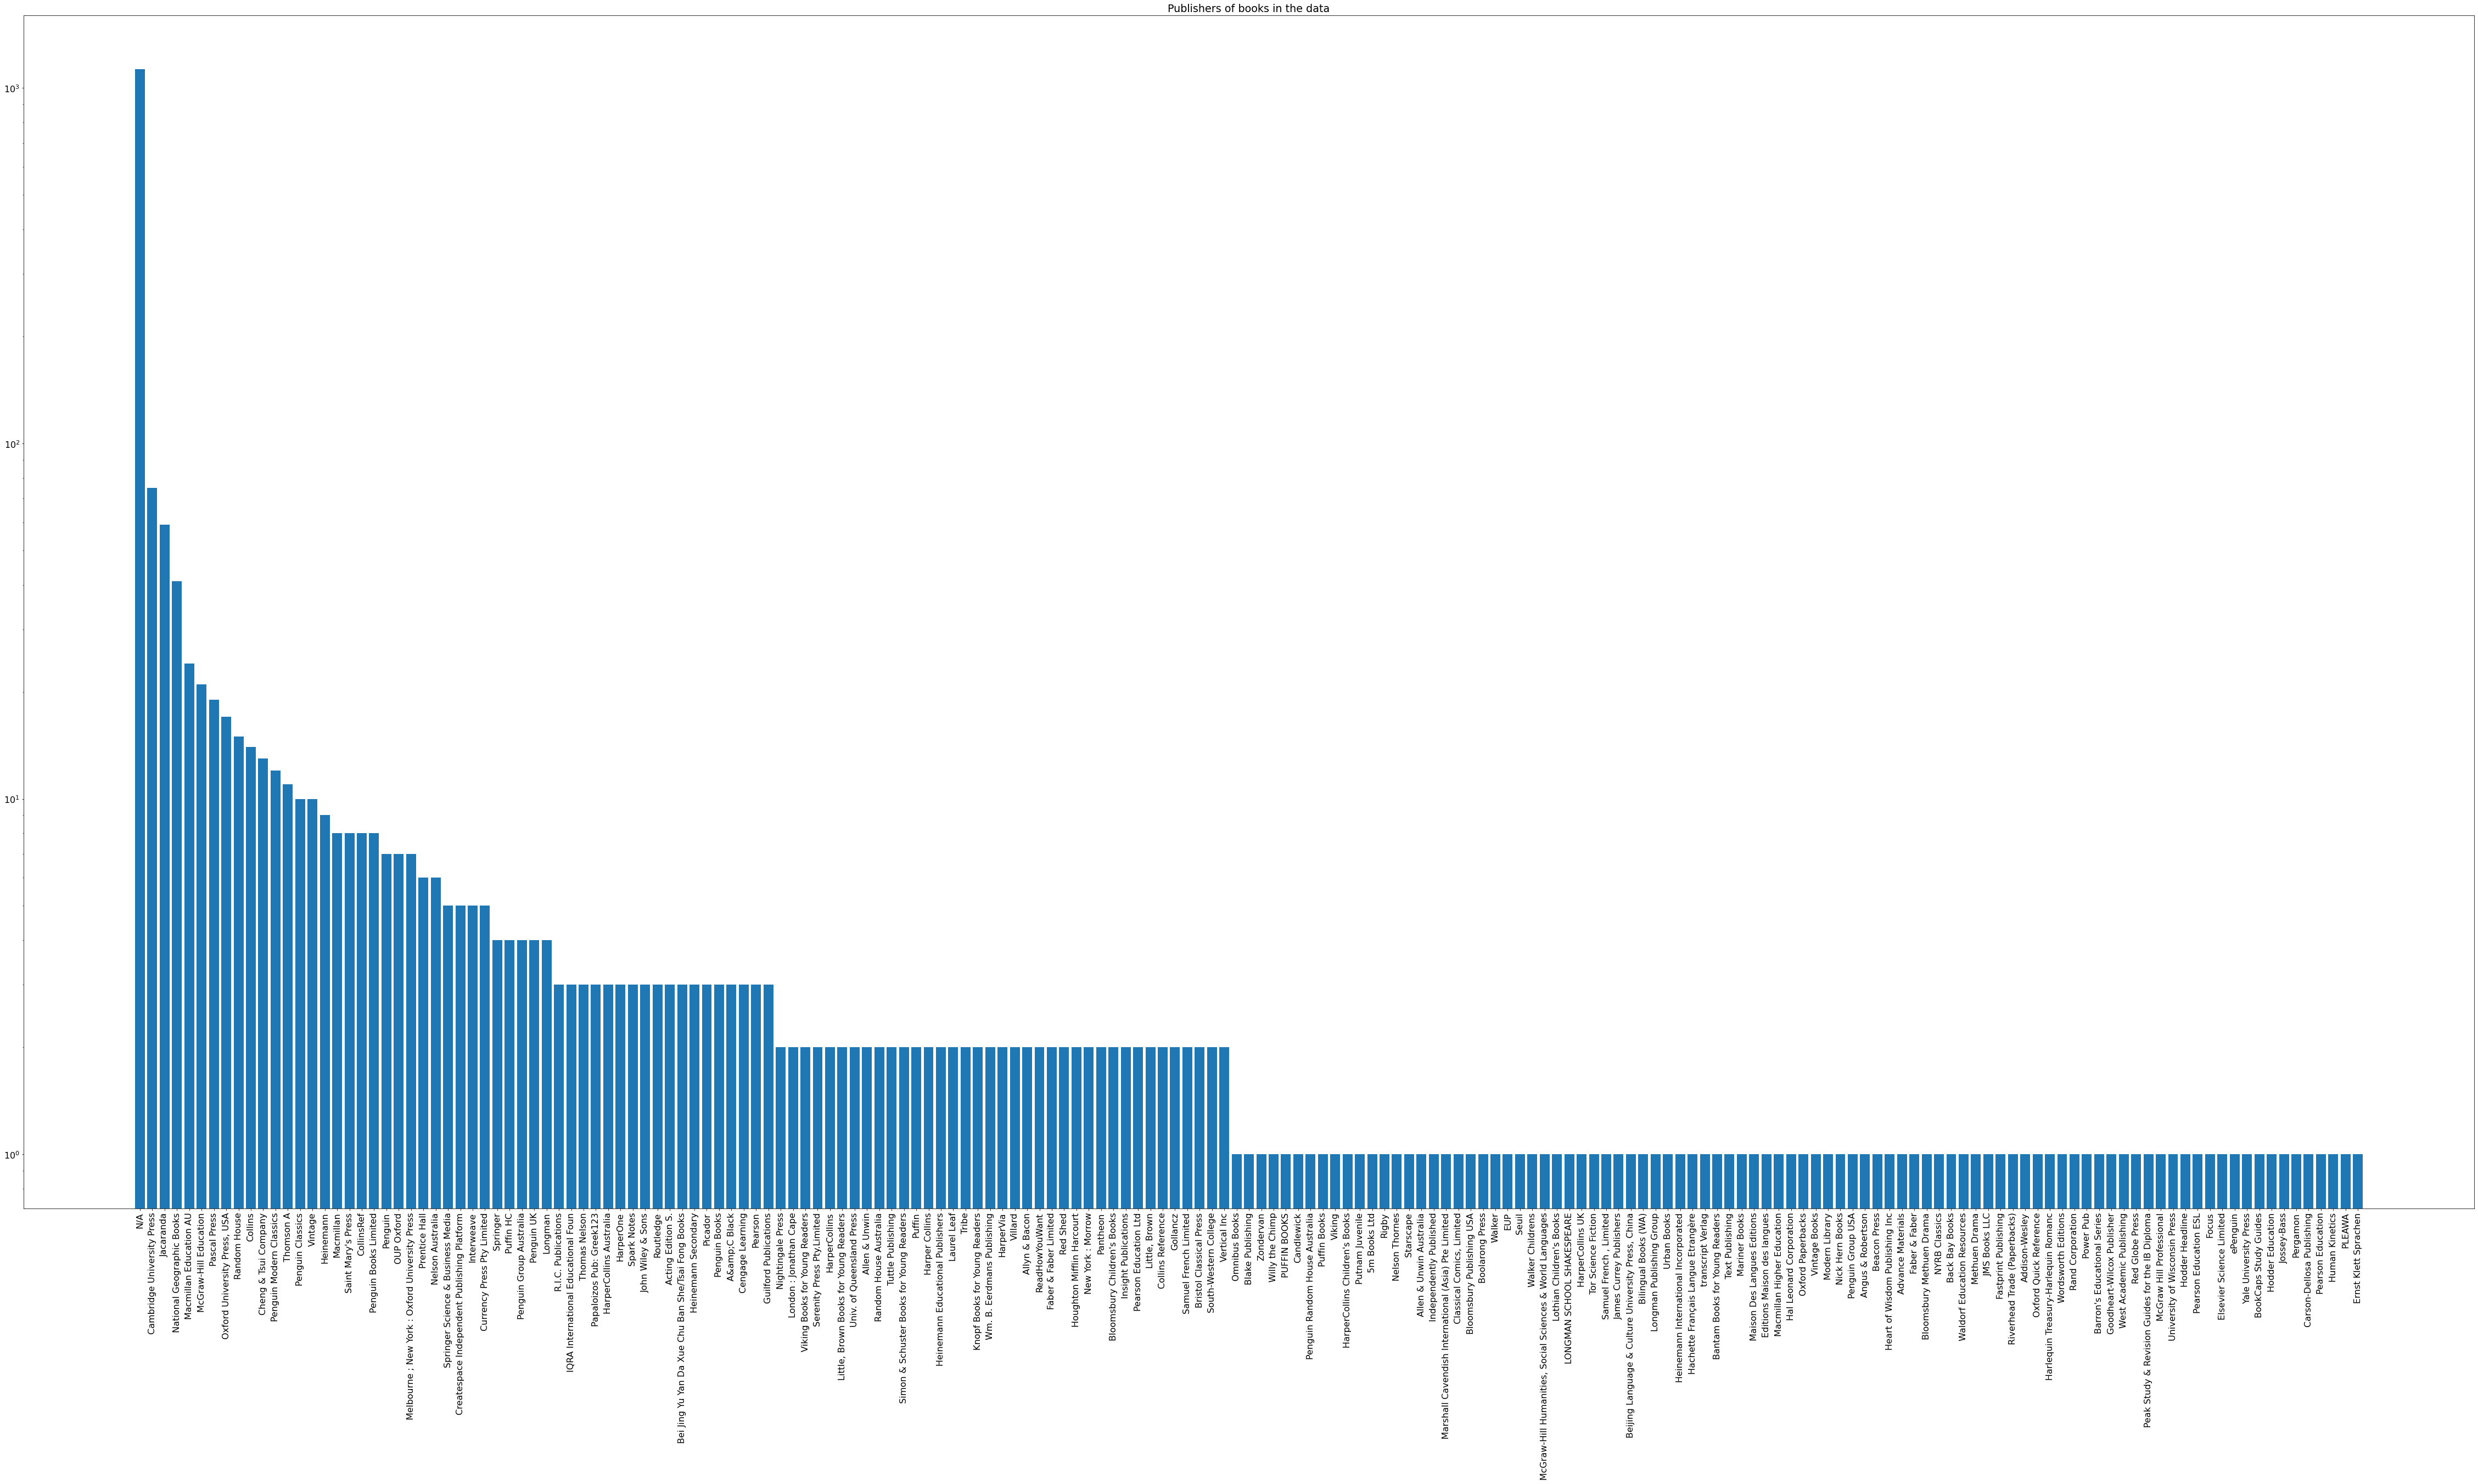


Number of known publishers of more than5 books in the data: 24


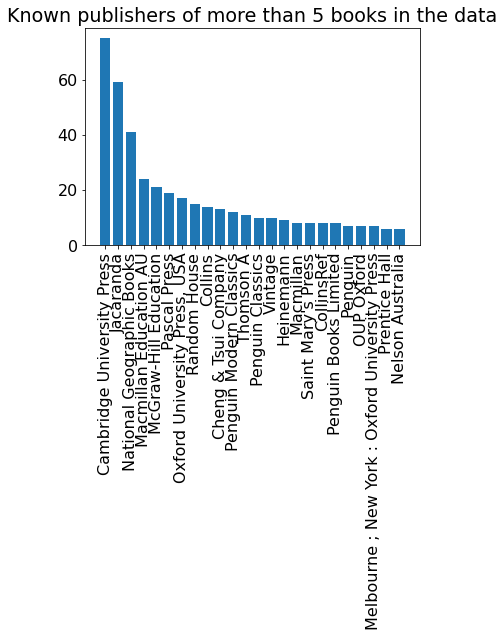


Total number of books in the data: 1804
Total number of books in the data with unknown publisher: 1129
Total number of books in the data from uncommon publishers: 260
Total number of books in the data from publishers of more than 5 books: 415


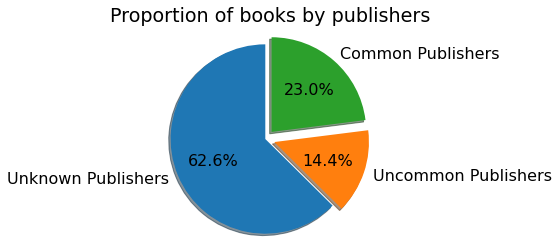

In [19]:

publisherSizeThreshold=5  # consider a publisher common if there are more than this number of unique books by that publisher in the data



#itterate through the publishers in df_enrichedBooks and populate a dictionary with the number of unique ISBN rows for each publisher
publisherDict={}
for publisher in df_enrichedBooks['publisher']:
    #print("Number of unique rows for publisher "+publisher+": "+str(df_enrichedBooks[df_enrichedBooks['publisher']==publisher].shape[0]))
    #print(publisher)
    if publisher not in publisherDict:
        publisherDict[publisher]=1
    else:
        publisherDict[publisher]+=1
print(publisherDict)


# plot the values in the publisherDict
fig, axs = plt.subplots(figsize=(80, 40))  # Bigger plot
plotDict(publisherDict,"Publishers of books in the data", True)  # Log scale on y axis

# remove the key "N/A" from the publisherDict dictionary
del publisherDict['N/A']
# remove keys where value is less than publisherSizeThreshold from the publisherDict dictionary
commonPublisherDict = {k: v for k, v in publisherDict.items() if v > publisherSizeThreshold}
# print the numbe of keys in the publisherDict dictionary
print("\nNumber of known publishers of more than"+str(publisherSizeThreshold)+" books in the data: "+str(len(commonPublisherDict)))
plotDict(commonPublisherDict,"Known publishers of more than "+str(publisherSizeThreshold)+" books in the data", False)  # Linear scale on y axis


totalBooks=df_enrichedBooks.shape[0]
commonPublisherBooks=sum(commonPublisherDict.values())
knownPublisherBooks=sum(publisherDict.values())
uncommonPublisherBooks=knownPublisherBooks-commonPublisherBooks

# create a list of common publishers
commonPublishersList=list(commonPublisherDict.keys())
# create a list of known publishers
knownPublishersList=list(publisherDict.keys())
# remobe the common publishers from the known publishers list
uncommonPublishersList = [x for x in knownPublishersList if x not in commonPublishersList]

# Hopw many books are there in the enrichedBooks data
print("\nTotal number of books in the data: "+str(totalBooks))
# The number of books where the publisher is unknown
print("Total number of books in the data with unknown publisher: "+str(totalBooks-knownPublisherBooks))
# How many books are there from uncommon publishers (less than publisherSizeThreshold books)
print("Total number of books in the data from uncommon publishers: "+str(uncommonPublisherBooks))
# How many books are there from common publishers (more than publisherSizeThreshold books)
print("Total number of books in the data from publishers of more than "+str(publisherSizeThreshold)+" books: "+str(commonPublisherBooks))
#

# Plot a pie chart showing the proportion of books from known publishers, the proportion of books from common publishers of the total number of books
labels = 'Unknown Publishers', 'Uncommon Publishers', 'Common Publishers'
sizes = [totalBooks-knownPublisherBooks, uncommonPublisherBooks, commonPublisherBooks]
explode = (0, 0.1, 0.1)  # only explode the 2nd and 3rd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Proportion of books by publishers")
plt.show()




Range of values for Year column in df_enrichedBooks: 0 to 12
Number of unique school_id, subject, year and state combinations in df_enrichedBooks: 657
Number of unique subject, year and state combinations in df_enrichedBooks: 382
Number of unique subject and year combinations in df_enrichedBooks: 150

Check the result of ISBNs used for each subject and year combination (head):
      Subject  Year  counts
0  ACCOUNTING     2       1
1  ACCOUNTING     9       3
2  ACCOUNTING    10       1
3  ACCOUNTING    11       2
4  ACCOUNTING    12      22


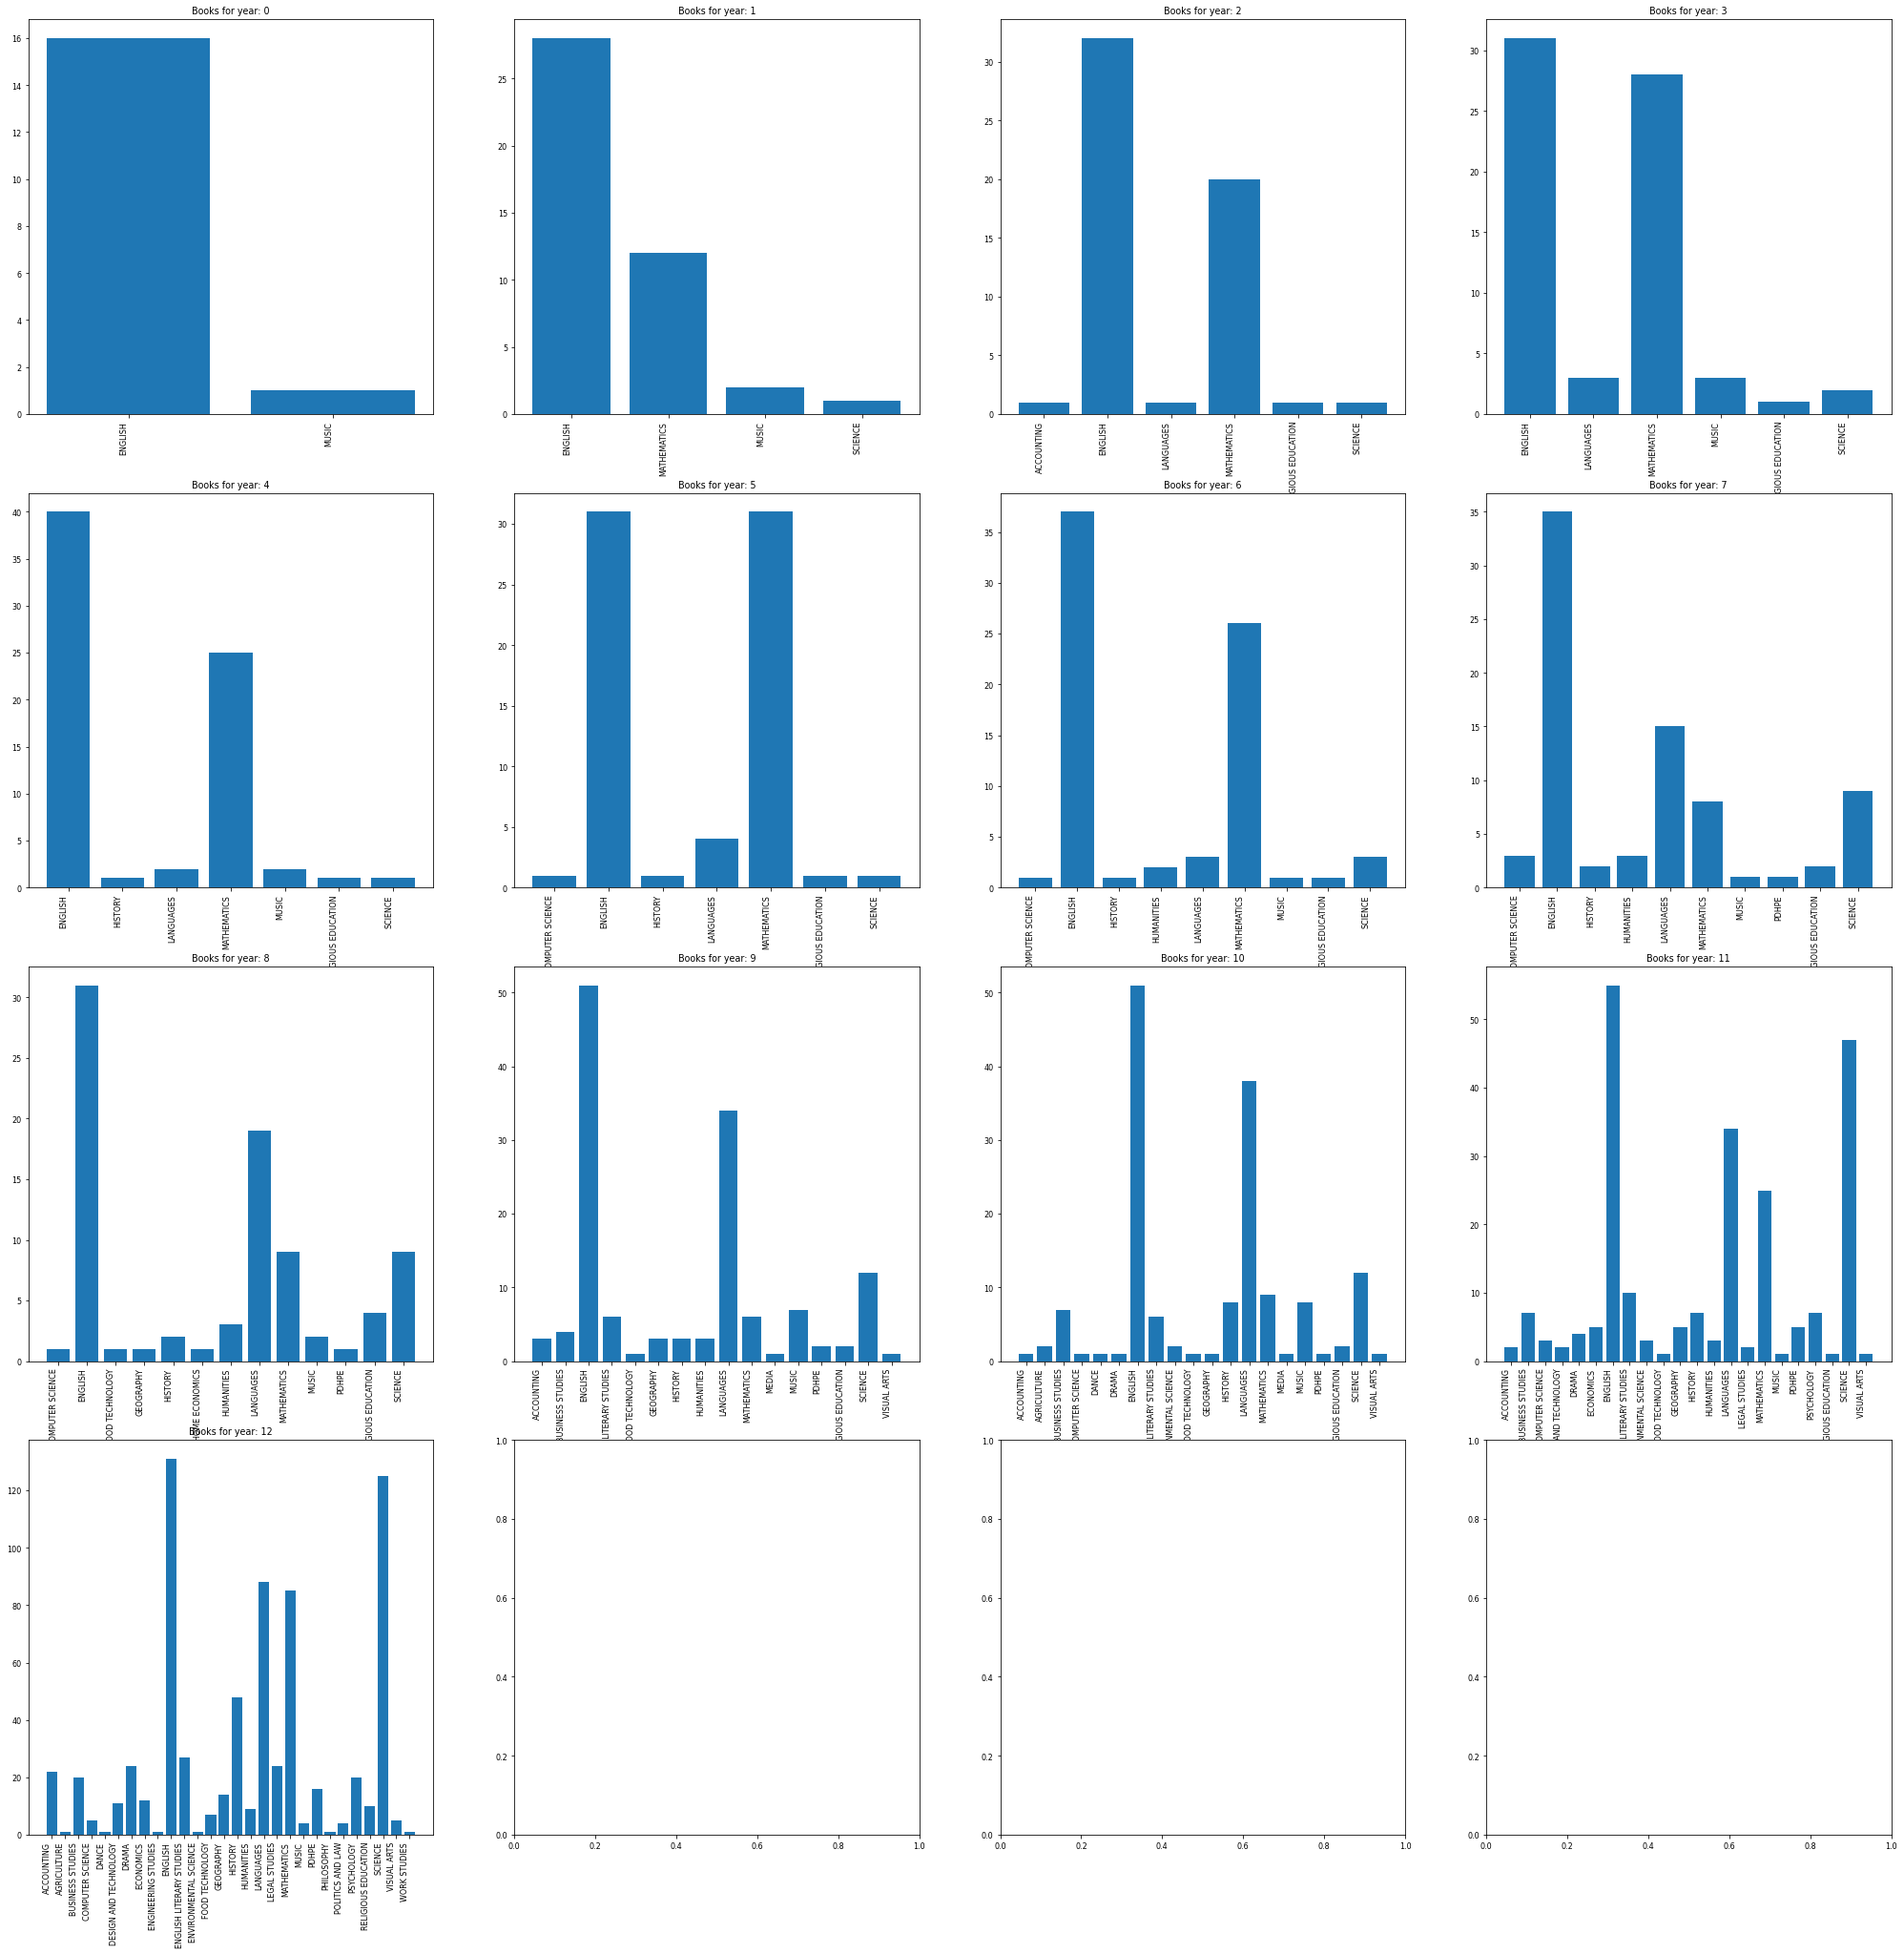

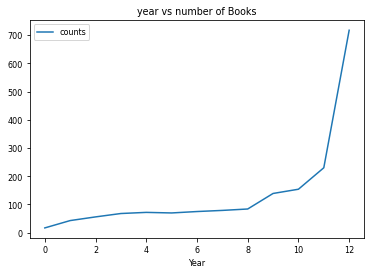

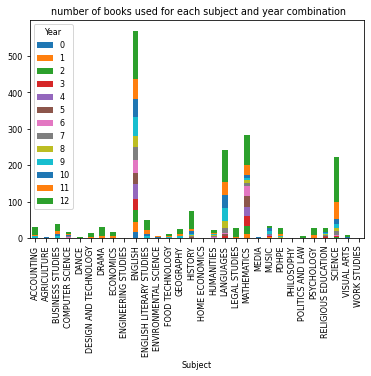

In [20]:

# Get the range of values for Year column in df_enrichedBooks
minYear=df_enrichedBooks['Year'].min()
maxYear=df_enrichedBooks['Year'].max()
print("Range of values for Year column in df_enrichedBooks: "+str(minYear)+" to "+str(maxYear))

# Print the number of unique [schoo, subject, year and state combinations] and [subjec, Year and state] combinations in df_enrichedBooks
print("Number of unique school_id, subject, year and state combinations in df_enrichedBooks: "+str(df_enrichedBooks.groupby(['School_ID','Subject','State',"Year"]).size().reset_index(name='counts').shape[0]))
print("Number of unique subject, year and state combinations in df_enrichedBooks: "+str(df_enrichedBooks.groupby(['Subject','State','Year']).size().reset_index(name='counts').shape[0]))
print("Number of unique subject and year combinations in df_enrichedBooks: "+str(df_enrichedBooks.groupby(['Subject','Year']).size().reset_index(name='counts').shape[0]))
#Get the number if ISBNs used for each subject and year combination
df_SubjectYear=df_enrichedBooks.groupby(['Subject','Year']).size().reset_index(name='counts')
print("\nCheck the result of ISBNs used for each subject and year combination (head):")
print(df_SubjectYear.head(5))

# Plot the number of ISBNs (books) used for each subject and year combination

# Set the font size
plt.rcParams.update({'font.size': 8})

# Create a figure with 3 subplots per row
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(35, 35))

# Loop over the years and plot the data for each year
for i, year in enumerate(range(minYear, maxYear+1)):
    # Get the data for this year
    data = df_SubjectYear[df_SubjectYear['Year']==year]

    # Plot the data on the appropriate subplot
    axs[i//4, i%4].bar(data['Subject'], data['counts'])
    axs[i//4, i%4].set_title("Books for year: "+str(year))
    plt.setp(axs[i//4, i%4].get_xticklabels(), rotation=90, ha="right")


# From df_enrichedBooks plot the number of ISBNs (books) for a year 
df_enrichedBooks.groupby(['Year']).size().reset_index(name='counts').plot(x='Year', y='counts', kind='line')
plt.title('year vs number of Books')

# Pivot the df_SubjectYear dataframe to show the number of ISBNs used for each subject and year combination 
# This is the same as the previous plot but in a different format
df_SubjectYear.pivot(index='Subject', columns='Year', values='counts').plot(kind='bar', stacked=True)
plt.title(' number of books used for each subject and year combination')

plt.show()




Explore the catgories of books in the data, going to get the top 10 and use them ad features, the others will be "otherCatagory" 

['Mathematics', 'English language', 'Juvenile Nonfiction', 'Fiction', 'Drama', 'Foreign Language Study', 'Science', 'Chemistry', 'Juvenile Fiction', 'Japanese language']


Text(0.5, 1.0, 'Number of each category in the df_enrichedBooks dataframe where the number of books is more than 20')

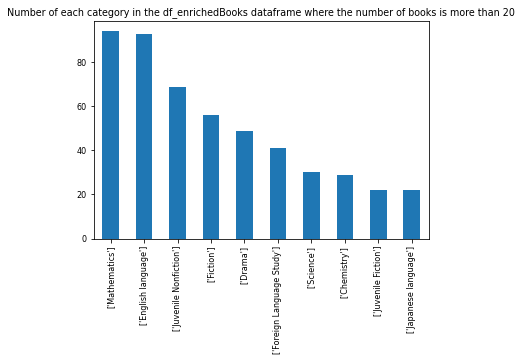

In [21]:


#set catagoriesList to the top 10 non N/A catagories in the df_enrichedBooks dataframe
catagoriesList=df_enrichedBooks[df_enrichedBooks['categories']!='N/A']['categories'].value_counts().head(10).index.tolist()
# strip [' and '] from the catagoriesList list
catagoriesList=[x.strip("['']") for x in catagoriesList]
# print the catagoriesList list
print(catagoriesList)

# Plot the number of each category in the df_enrichedBooks dataframe wheere the number of books is more than 20  
df_enrichedBooks[df_enrichedBooks['categories']!='N/A']['categories'].value_counts()[df_enrichedBooks[df_enrichedBooks['categories']!='N/A']['categories'].value_counts()>20].plot(kind='bar')
plt.title('Number of each category in the df_enrichedBooks dataframe where the number of books is more than 20')



Merging the text where description is missing and a text snippet exists use the text smippet, and then title, dollowed by catagories and finally Subject.

Continue manupulation of the df_enrichedBooksWork data frame by applying the information discovered from EDA. Reduce dimentions/columns thaat don't have information:

1.  Drop Columns with all N/A values: ['hasReprints', 'hasReviews', 'hasTranslations', 'hasVersions', 'subjects']
2.  Drop Columns with only two values, one of which is N/A: ['hasCorrections', 'printType', 'country']
3.  Where language is N/A make it en
4.  Where issued in not N/A set the year as the last year (example 1999-2013 becomes 2013)
5.  Drop columns pageCount, avverageRating, ratingsCount, saleability -> making a call that these will not be relevant


5 - should I also drop the Authors ?  - No the authors cataroty will be added as columns in the feature frame
6. As for above needs to be done for Publishers.

In [73]:

# take a copy of the df_enrichedBooks dataframe before manipulation
df_enrichedBooksWork=df_enrichedBooks.copy()

#how many books dont have a title
print("Number of books contain N/A in the title column: "+str(df_enrichedBooksWork[df_enrichedBooksWork['title']=="N/A"].shape[0]))
#how many books dont have a description 
print("Number contain N/A in the description column: "+str(df_enrichedBooksWork[df_enrichedBooksWork['description']=="N/A"].shape[0]))

# Consolidating to make sure all books have a description and a title.

# for rows where description is "N/A" set the description to textSnippet
df_enrichedBooksWork.loc[df_enrichedBooksWork['description']=="N/A", 'description'] = df_enrichedBooksWork['textSnippet']
# if still the description is "N/A" set the description to title
df_enrichedBooksWork.loc[df_enrichedBooksWork['description']=="N/A", 'description'] = df_enrichedBooksWork['title']
# if still the description is "N/A" set the description to categories
df_enrichedBooksWork.loc[df_enrichedBooksWork['description']=="N/A", 'description'] = df_enrichedBooksWork['categories']
# if still the description is "N/A" set the description to Subject
df_enrichedBooksWork.loc[df_enrichedBooksWork['description']=="N/A", 'description'] = df_enrichedBooksWork['Subject']
# for books where the title is "N/A" set the title to description
df_enrichedBooksWork.loc[df_enrichedBooksWork['title']=="N/A", 'title'] = df_enrichedBooksWork['description']

# How's it looking after the consolidation

print("After consolidation number of books contain N/A in the title column: "+str(df_enrichedBooksWork[df_enrichedBooksWork['title']=="N/A"].shape[0]))
print("After consolidation number of books contain N/A in the description column: "+str(df_enrichedBooksWork[df_enrichedBooksWork['description']=="N/A"].shape[0]))
print("Number of rows where description is N/A: "+str(df_enrichedBooksWork[df_enrichedBooksWork['description']=="N/A"].shape[0]))

# print the enrichedBooksWork decsription column for 10 rows
# print("enrichedBooksWork decsription column for 10 rows:")
# print(df_enrichedBooksWork['description'].head(10))


print("Column count in df_enrichedBooksWork before drop: "+str(len(df_enrichedBooksWork.columns)))
# drop columns that don't have any or have very little information 
df_enrichedBooksWork.drop(['hasReprints', 'hasReviews', 'hasTranslations', 'hasVersions', 'subjects', 'hasCorrections', 'printType', 'country', 'pageCount', 'averageRating', 'ratingsCount', 'saleability' ], axis=1, inplace=True)
print("Column count in df_enrichedBooksWork after drop: "+str(len(df_enrichedBooksWork.columns)))

# for rows where language is "N/A" set the language to en
df_enrichedBooksWork.loc[df_enrichedBooksWork['language']=="N/A", 'language'] = "en"

# adjut the issue/published date to be just the year
# for rows where issued is not "N/A" set issued to the last 4 characters of the issued column
df_enrichedBooksWork.loc[df_enrichedBooksWork['issued']!="N/A", 'issued'] = df_enrichedBooksWork['issued'].str[-4:]
print(df_enrichedBooksWork['issued'].head(5))



# save df_enrichedBooksWork to a new excel file
df_enrichedBooksWork.to_excel("/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3\MA5851_SP82_2023_A1_Data_EnrichedWork.xlsx", sheet_name='ISBN_Data', index=False)

df_enrichedBooksWork.info()




Number of books contain N/A in the title column: 185
Number contain N/A in the description column: 705
After consolidation number of books contain N/A in the title column: 0
After consolidation number of books contain N/A in the description column: 0
Number of rows where description is N/A: 0
Column count in df_enrichedBooksWork before drop: 28
Column count in df_enrichedBooksWork after drop: 16
0    2004
1     N/A
2    2021
3    2012
4    2017
Name: issued, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804 entries, 0 to 1803
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   School_ID       1804 non-null   int64 
 1   State           1804 non-null   object
 2   Year            1804 non-null   int64 
 3   Subject         1804 non-null   object
 4   ISBN            1804 non-null   int64 
 5   issued          1804 non-null   object
 6   type            1804 non-null   object
 7   title          

Now that there is a description column that contains tect where tect is available, eother from description itself or if that was empty from textSnippet, title, categories  or Subject.
Also title  contains text in most instances.

0    seri suppli teacher comprehens rang idea exper...
1                        suitabl lower primari student
Name: description, dtype: object
Top 20 words in the description column of df_textAnalysis:
student       1081
book           664
new            604
includ         483
edit           446
activ          398
provid         373
skill          371
studi          360
year           344
australian     328
learn          326
design         324
text           312
languag        309
curriculum     307
seri           305
use            290
featur         289
practic        289
dtype: int64


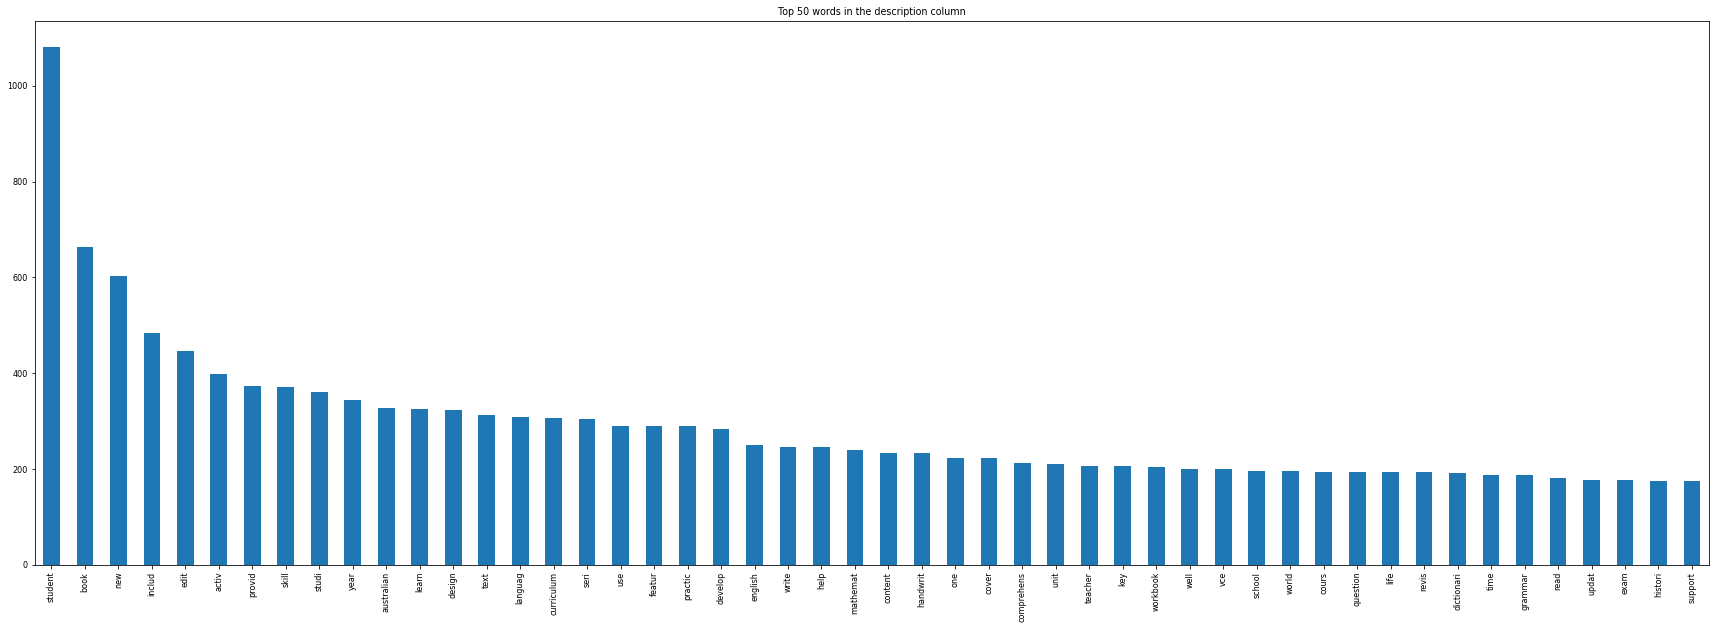

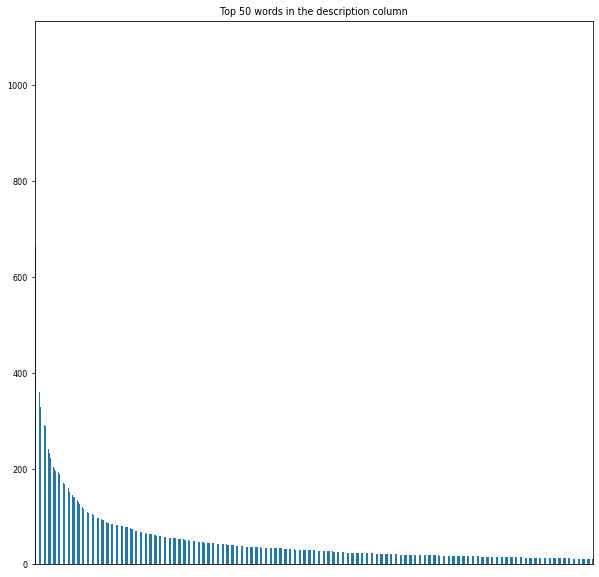

Number of unique words in the description column: 5770
Number of words that occur less then 50 times in the description column: 5494
Words that occur between 50 and 200 times in the description column:
school       195
world        195
cours        194
question     194
life         193
            ... 
product       52
recent        52
australia     51
align         51
even          51
Length: 235, dtype: int64


In [74]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

exclude_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# Create a tokenize based on a regular expression.
# "[a-zA-Z0-9]+" captures all alphanumeric characters
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+")

# this cleans up the passed text by removing stop words, lemmatizing and stemming
# the list flag is used to indicate if the return should be a list or a joined string
def clean_text(text,list):
    text = text.lower()
    words = tokenizer.tokenize(text)
    # exclude words that are numeric only
    words = [w for w in words if not w.isnumeric()]
    words = [w for w in words if w not in exclude_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [ps.stem(w) for w in words if w not in exclude_words]
    
    if list:
        return words
    else:
        return ' '.join(words)



# create a dataframe for analysis with a single column called description
df_textAnalysis = pd.DataFrame(columns=['description'])
df_textAnalysis['description'] = df_enrichedBooksWork['description']
df_textAnalysis = df_textAnalysis['description'].apply(clean_text,args=(False,))
print(df_textAnalysis.head(2))

# print the top 50 words in the description column of df_textAnalysis
print("Top 20 words in the description column of df_textAnalysis:")
print(df_textAnalysis.str.split(expand=True).stack().value_counts()[:20])


# plot the top 50 words in the description column 
plt.figure(figsize=(30,10))
df_textAnalysis.str.split(expand=True).stack().value_counts()[:50].plot(kind='bar')
plt.title('Top 50 words in the description column')
plt.show()

# plot 1000 of the words in the description column to verify Ziph's law 
plt.figure(figsize=(10,10))
df_textAnalysis.str.split(expand=True).stack().value_counts()[:1000].plot(kind='bar')
plt.title('Top 50 words in the description column')
plt.xticks([])
plt.show()

# How many inique words are in the description column
print("Number of unique words in the description column: "+str(df_textAnalysis.str.split(expand=True).stack().value_counts().shape[0]))

# Now need to figure out how many words occur less then 50 times in the description column
print("Number of words that occur less then 50 times in the description column: "+str(df_textAnalysis.str.split(expand=True).stack().value_counts()[df_textAnalysis.str.split(expand=True).stack().value_counts() < 50].shape[0]))

# print the words that occur between 50 and 200 times in the description column, to get a sense of information theuy may carry
print("Words that occur between 50 and 200 times in the description column:")
print(df_textAnalysis.str.split(expand=True).stack().value_counts()[(df_textAnalysis.str.split(expand=True).stack().value_counts() > 50) & (df_textAnalysis.str.split(expand=True).stack().value_counts() < 200)])




Analysis to determine the number of words that should be considered as features. and build a dictionary of words that can be used for vectorisation

In [75]:
exclude_words = set(stopwords.words('english'))

# Now extending the exclude words based on anbalysis
# define additional set of stopwords relevant for this corpus (from the earlier analysis)
custom_exclude_words = ['student', 'book', 'new', 'includ', 'edit', 'year', 'learn', 'content', 'one', 'cover', 'unit', 'well', 'question', 'school','cours',"1st","20th","2nd","3rd",
                        "4th","5th","6th","7th","8th","9th","10th","20th","30th","40th","50th","60th","70th","80th","90th","100th"]

# add a list of stopwords to the stop_words set
exclude_words.update(set(custom_exclude_words))

# Create a dictionary of words and their count
wordDict = {}

# for each row in the description column of df_enrichedBooksWork, clean the text and print the returned list
for index, row in df_enrichedBooksWork.iterrows():
    wordListForRow=clean_text(row['description'],True)
    # add the cleaned list of words to a dictionaty of words
    # if the word is already in the dictionary, increment the count
    # if the word is not in the dictionary, add it with a count of 1
    for word in wordListForRow:
        if word in wordDict:
            wordDict[word] += 1
        else:
            wordDict[word] = 1

# order the dictionary by the count of the words
wordDict = sorted(wordDict.items(), key=lambda x: x[1], reverse=True)

# How many words are in the dictionary
totalWords = len(wordDict)
print("Number of words in the dictionary: "+str(totalWords))

# remove words where the frequency is 200 or more
# this is to remove words that are common and probably do not add much value
# the number 200 was chosen based on the analysis of the top 1000 words
wordDict = [x for x in wordDict if x[1] < 200] 

# remove words that are in the custom_exclude_words list
# this is to exclude words seen in the corpus that are probably not relevant
wordDict = [x for x in wordDict if x[0] not in custom_exclude_words]

# remove words where the frequency is less than 4 
# this is to remove words that are not common and probably do not add much value
# this may be because of spelling errors etc
# the number 4 was chosen based on the analysis of the top 1000 words
wordDict = [x for x in wordDict if x[1] > 4]


totalWords = len(wordDict)
print("Number of words in the dictionary now: "+str(totalWords))

print("Top 20 words in the dictionary now:")
print(wordDict[:20])



Number of words in the dictionary: 5751
Number of words in the dictionary now: 2023
Top 20 words in the dictionary now:
[('world', 195), ('revis', 193), ('life', 193), ('dictionari', 192), ('time', 188), ('grammar', 188), ('read', 182), ('updat', 177), ('exam', 177), ('support', 175), ('histori', 175), ('work', 171), ('play', 170), ('guid', 169), ('concept', 168), ('word', 167), ('base', 167), ('access', 166), ('oxford', 166), ('understand', 162)]


Use the wordDict to constrain the words in the description column of the df_enrichedBooksWork dataframe so that it can be used to vectorise the text

In [76]:
# first clean up the text in the description column of df_enrichedBooksWork
df_enrichedBooksWork['description'] = df_enrichedBooksWork['description'].apply(clean_text,args=(False,))

# the datadrame now contains cleand (lower case, lematised and stemmed) text in the description column with stop words and numbers removed

print(df_enrichedBooksWork['description'].head(5))

# this function takes a text string and returns a a string of words
# the string of words is limited to those that are in the wordDict only
# noting wordDict was built during corpus analysis
def final_clean_text(text):
    text = text.lower()
    words = tokenizer.tokenize(text)
    # check if the word is in the stop words list
    # exclude words that are not keys in wordDict
    words = [w for w in words if w in wordList]
    return ' '.join(words)

# make a list out of the keys in wordDict so that it can be used for final_clean_text
wordList = [x[0] for x in wordDict]

# apply the vectorise_text function to the description column of df_enrichedBooksWork
df_enrichedBooksWork['final_description'] = df_enrichedBooksWork['description'].apply(final_clean_text)

print(df_enrichedBooksWork['final_description'].head(5))



0    seri suppli teacher comprehens rang idea exper...
1                                suitabl lower primari
2    anniversari edit wilfrid gordon mcdonald partr...
3    imath investig base numeraci program comprehen...
4    australian curriculum edit target math foundat...
Name: description, dtype: object
0    suppli rang idea experi enabl child find becom...
1                                suitabl lower primari
2    second collabor author illustr magic first pub...
3    imath investig base numeraci program address p...
4    target math foundat specif written meet requir...
Name: final_description, dtype: object


The words in final_description of df_enrichedBooksWork can be transformed using TfidVectorizer in to Tf-idf representation
The tfidf_matrix is converted to an array so that it can be used to create a word feature dataframe (ISBN in column 1 and a column for each word)  
The created feature data frame df_Words is to be mearged with the feature table

In [77]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix

# Use TfidfVectorizer to transform the descriptions now in df_enrichedBooksWork['final_description']
tfidf = TfidfVectorizer()


tfidf_matrix = tfidf.fit_transform(df_enrichedBooksWork['final_description'])

print(tfidf_matrix.shape)
#print(print(tfidf_matrix.shape))
tfidf_matrix

# convert the tfidf_matrix to an array
wordsArray = tfidf_matrix.toarray()
# how many rows in the array
print("Number of rows in the array, (ie. 1 for each row in the ISBN data): "+str(wordsArray.shape[0]))  # Noting duplicate ISBN's are included but this is OK

# create a new data frame with the ISBN and the wordsArray
#df_Words = pd.DataFrame(wordsArray, index=df_enrichedBooksWork['ISBN'])
df_Words = pd.DataFrame(wordsArray, df_enrichedBooksWork['ISBN'])

# convert df_Words to an ordinary data frame
df_Words = df_Words.reset_index()


#print the first 5 columns of df_Words
print("First 10 columns of df_Words:")
print(df_Words.iloc[1:,0:10].head(10))



(1804, 2007)
Number of rows in the array, (ie. 1 for each row in the ISBN data): 1804
First 10 columns of df_Words:
             ISBN    0    1    2    3    4    5    6         7    8
1   9780648237327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
2   9781742990682  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
3   9781741351750  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
4   9781742152196  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.059564  0.0
5   9780310709626  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
6   9780648237327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
7   9781876424022  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
8   9781740202954  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
9   9781925487350  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0
10  9781741352795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0


 df_enrichedBooksWork is now ready to be used to construct the feature frame.

5. create a feature frame
6. In the feature frame add columns for language book languages: ['en' 'ar' 'un' 'ja' 'de' 'el' 'fr' 'zh-CN' 'es']
7. In the feature frame add columns for 'Book/Illustrated', 'Book', 'Audio book', 'Book/Braille', 'Sound', 'Sound/Other sound', 'Map', 'Map/Atlas', 'Book/Large print', 'Article/Book chapter', 'Government publication', 'Microform', 'Periodical', 'Periodical/Journal, magazine, other', 'Video', 'Article/Working paper', 'Sound/Recorded music', 'Conference Proceedings', 'Thesis', 'Article/Review', 'Article/Journal or magazine article', 'Article', 'Article/Report', 'Published' 
8. There are 24 known publishers of more than 5 books in commonPublisherDict  commonPublishe, unkommonPublisher, unknownPublishe the columns should be added to the feature frame.
9. As with publishers do this with Authors (popularAuthor, regularAuthor otherAuthor)
9. Integrate the vectorised text corpus in to the feature frame.




In [78]:
#Two convinience functions for code and decode using a dictionary
def getCode(myDict, key):
    return myDict[key]
def getDecode(myDict, val):
    return list(myDict.keys())[list(myDict.values()).index(val)]

# Create a list of states, which we'll use to build features in the feature frame
stateList = df_enrichedBooksWork['State'].unique()

# populate a list of subjects from the data, , which we'll use to build features in the feature frame by itteratin
subjectList = df_enrichedBooksWork['Subject'].unique()
subjectList = ["subj_"+x for x in subjectList]

# Create a list of years, which we'll use to build features in the feature frame
yearList = df_enrichedBooksWork['Year'].unique()
yearList = ["yr_"+str(x) for x in yearList]

# The issued data will be used to set these features
issuedList = ["0-5years","5-10years","10+years"]

# create a type list by extracting the keys from typeDict
typeList = list(typeDict.keys())
typeList = ["ty_"+str(x) for x in typeList]

# The authors are classed as populatAuthor, generalAuthor and otherAuthor  
authorTypeList = ["popularAuthor","generalAuthor","otherAuthor"]

# The publishers are classed as populatAuthor, generalAuthor and otherAuthor  
publisherTypeList = ["commonPublisher", "uncommonPublisher", "unknownPublisher"]

# Catagories  (catagoriesList from top 10 catagories oin the data was populated earlier)
# prepend the catagory name with "cat_" to make it a feature
#set catagoriesList to the top 10 non N/A catagories in the df_enrichedBooks dataframe
categoriesList=df_enrichedBooks[df_enrichedBooks['categories']!='N/A']['categories'].value_counts().head(10).index.tolist()
# strip [' and '] from the catagoriesList list
categoriesList=[x.strip("['']") for x in categoriesList]
categoriesList = ["cat_"+x for x in categoriesList]


featureDimentions=["ISBN", "State", "Year", "Subject", "isMature", "isEbook"]

# add subjectList columns to featureDimentions
featureDimentions.extend(subjectList)
# add issuedList columns to featureDimentions
featureDimentions.extend(issuedList)
# add typeList columns to featureDimentions
featureDimentions.extend(typeList)
# add yearList columns to featureDimentions
featureDimentions.extend(yearList)
# add authorTypeList columns to featureDimentions
featureDimentions.extend(authorTypeList)
# add publisherTypeList columns to featureDimentions
featureDimentions.extend(publisherTypeList)
# add catagoriesList columns to featureDimentions
featureDimentions.extend(categoriesList)
# add stateList columns to featureDimentions
featureDimentions.extend(stateList)
# add languageList columns to featureDimentions
featureDimentions.extend(languageList)


# Construct the feature dataframe columns
print(featureDimentions)
# how many features are there
print(len(featureDimentions))



['ISBN', 'State', 'Year', 'Subject', 'isMature', 'isEbook', 'subj_ENGLISH', 'subj_MUSIC', 'subj_MATHEMATICS', 'subj_SCIENCE', 'subj_LANGUAGES', 'subj_ACCOUNTING', 'subj_RELIGIOUS EDUCATION', 'subj_HISTORY', 'subj_COMPUTER SCIENCE', 'subj_HUMANITIES', 'subj_PDHPE', 'subj_HOME ECONOMICS', 'subj_FOOD TECHNOLOGY', 'subj_GEOGRAPHY', 'subj_ENGLISH LITERARY STUDIES', 'subj_BUSINESS STUDIES', 'subj_MEDIA', 'subj_VISUAL ARTS', 'subj_DRAMA', 'subj_AGRICULTURE', 'subj_DANCE', 'subj_ENVIRONMENTAL SCIENCE', 'subj_PSYCHOLOGY', 'subj_DESIGN AND TECHNOLOGY', 'subj_LEGAL STUDIES', 'subj_WORK STUDIES', 'subj_POLITICS AND LAW', 'subj_ECONOMICS', 'subj_ENGINEERING STUDIES', 'subj_PHILOSOPHY', '0-5years', '5-10years', '10+years', 'ty_Book/Illustrated', 'ty_Book', 'ty_Audio book', 'ty_Book/Braille', 'ty_Sound', 'ty_Sound/Other sound', 'ty_Map', 'ty_Map/Atlas', 'ty_Book/Large print', 'ty_Article/Book chapter', 'ty_Government publication', 'ty_Microform', 'ty_Periodical', 'ty_Periodical/Journal, magazine, oth

In [79]:
import datetime

#create a featureDataframe with featureDimentions as the columns
featureDataframe = pd.DataFrame(columns=featureDimentions)
# set the ISBN column as the index
# >>> featureDataframe.set_index('ISBN', inplace=True)
# Truncate for repeated runs of this cell
featureDataframe = featureDataframe.truncate()
featureRowDict = {} # This will be the derived row for the feature data frame
subjectDict={}
dataDict={}
yearDict={}
issuedDict={}


def clearDicts():
    # clear the dictionaries
    subjectDict.clear()
    dataDict.clear()
    yearDict.clear()
    #issuedDict().clear()
    featureRowDict.clear()





# function to return a dictionary with column set according tje possible values of the poriginal data passed data column name and prefix used in the feature frame
def vectorise(dataColumnValue,prefix,dataColumnValuesList):
    # prepend prefix to subject string
    dataDictColumnName = prefix+dataColumnValue
    # create a dictionary with keys set to values in subjectList
    dataDict = dict.fromkeys(dataColumnValuesList, 0)
    # itterate through subjectDict and set the value to 1 if the key matches the subject
    for key in dataDict:
        if key == dataDictColumnName:
            dataDict[key] = 1
        else:
            dataDict[key] = 0
    return dataDict

# function to merge dictionaries
def mergeDicts(dict1, dict2):
    res = {**dict1, **dict2}
    return res



# function to return dictionary according to book age
def getIssuedDict(issuedYear):
    # get current year as a string
    currentYear = str(datetime.datetime.now().year)
    # create a dictionary with keys set to values in subjectList
    issuedDict = dict.fromkeys(issuedList, 0)
    # work out age by subrteacting issued year from current year
    if issuedYear == "N/A":
        issuedYear = str(currentYear)
    age = int(currentYear) - int(issuedYear)
    # if the age is < 5 set the issuedDict['0-5years'] to 1
    if age < 5:
        issuedDict['0-5years'] = 1
    # if the age is < 10 set the issuedDict['5-10years'] to 1
    elif age < 10:
        issuedDict['5-10years'] = 1
    # if the age is > 10 set the issuedDict['10+years'] to 1
    else:
        issuedDict['10+years'] = 1
    return issuedDict

 
# function to return 1 if the parameter is "mature" and 0 otherwise
# Although in the data there are VERY few mature books, I have decided to keep this column as it may be an important feature and data may change in the future
def isMature(maturityRating):
    # convert maturityRating to lower case
    maturityRating = maturityRating.lower()
    if maturityRating == "mature":
        return 1
    else:
        return 0
    

# convert the string "False" to 0 and "True" to 1
def isTrue(astring):
    astring = astring.lower()
    if astring == "true":
        return 1
    else:
        return 0
    
# function to return dictionary according to pulisher type
def getPublisherTypeDict(publisher, publisherTypeList):
    # create a dictionary with keys set to values in publisher type list
    publisherTypeDict = dict.fromkeys(publisherTypeList, 0)
    # if the publisher is in the commonPublishersList 
    if publisher in commonPublishersList:
        publisherTypeDict['commonPublisher'] = 1
    # if the publisher is in the uncommonPublisherList 
    elif publisher in uncommonPublishersList:
        publisherTypeDict['uncommonPublisher'] = 1
    else:
        publisherTypeDict['unknownPublisher'] = 1
    return publisherTypeDict


# function to return dictionary according to author type
# noting that the authorlist can contain authors that are popular, general and other simultaneously
def getAuthorTypeDict(authors, authorTypeList):
    # if auhors is "N/A" set it to "[]"
    if authors == "N/A":
        authors = "[]"
    # convert authors string to a list
    authors = eval(authors)
    # create a dictionary with keys set to values in author type list
    authorTypeDict = dict.fromkeys(authorTypeList, 0)
    # if any of the authors in the author list is in the commonAuthorsList
    #print(popularAuthorsList)
    for ca in authors:
        #print (ca)
        if ca in popularAuthorsList:
         #   print ("in populat authors list")
            authorTypeDict['popularAuthor'] = 1
        elif ca in regularAuthorsList:
               # print ("in regular authors list")
                authorTypeDict['generalAuthor'] = 1 
        else:
            #print ("in other authors list")
            authorTypeDict['otherAuthor'] = 1
    return authorTypeDict

# function to return dictionary according to book type 
# noting that the booktype cam be multiple types simultaneously
def getBookTypeDict(types, typeList):
    # if type is "N/A" set it to "[]"
    if types == "N/A":
        types = "[]"
    # convert type string to a list
    types = eval(types)
    # create a dictionary with keys set to values in book type list
    bookTypeDict = dict.fromkeys(typeList, 0)
    # for each type in the list of types set the corresponding key to 1
    for t in types:
        #print(">t: "+t)
        # prepend "ty_" to the type string
        t = "ty_"+t
        bookTypeDict[t] = 1 
    return bookTypeDict


#  read each row of df_enrichedBooksWork and pipulate data appropriatly in to the vector feature datafeame
for index, row in df_enrichedBooksWork.iterrows():
    featureRowDict={'ISBN': row['ISBN'], 'State': row['State'], 'Year': row['Year'], 'Subject': row['Subject'],
                    'isMature': isMature(row['maturityRating']), 'isEbook': isTrue(row['isEbook']) }
    # populate the featureRowDict so it can be used to create the feature data  frame row
    featureRowDict=mergeDicts(featureRowDict,vectorise(row['Subject'], "subj_",subjectList))
    featureRowDict=mergeDicts(featureRowDict,vectorise(row['State'], "",stateList))
    featureRowDict=mergeDicts(featureRowDict,vectorise(str(row['Year']), "yr_",yearList))
    featureRowDict=mergeDicts(featureRowDict,vectorise(row['categories'].strip("['']"), "cat_",categoriesList))  # Noting only top 10 catagories are used
    featureRowDict=mergeDicts(featureRowDict,vectorise(row['language'], "",languageList))
    featureRowDict=mergeDicts(featureRowDict,getAuthorTypeDict(row['authors'],authorTypeList))
    featureRowDict=mergeDicts(featureRowDict,getPublisherTypeDict(row['publisher'],publisherTypeList))
    featureRowDict=mergeDicts(featureRowDict,getBookTypeDict(row['type'],typeList))  
    featureRowDict=mergeDicts(featureRowDict,getIssuedDict(row['issued']))
                              
    # add the row to the feature data frame from featureRowDict
    featureDataframe = featureDataframe.append(featureRowDict, ignore_index=True)
    #break   # remove this break to print all the rows





# overwrite the featureDataframe to a csv file
featureDataframe.to_csv('/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3/featureDataframe.csv')




We now have a fully populated featureDataframe for Metadata elements and it is ready to be joined with df_Words, which has all the (very many) features from the NLP analysis of the description text

The metadata frame created is binary, however, the df_Words features are created using the tf-ids vecrtorisor and so are not binary, once the metadata feature data frame is joined (by ISBN) df_Words a Cosine similarity matrix can be created

In [80]:
print("Number of rows in featureDataframe: "+str(len(featureDataframe.index)))
print("Number of columns in featureDataframe: "+str(len(featureDataframe.columns)))
print("Number of rows in df_Words: "+str(len(df_Words.index)))
print("Number of columns in df_Words: "+str(len(df_Words.columns)))

# The df_words dataframe has duplicates that we need to remove before merging
# remove duplicates from the df_Words dataframe
df_WordsNoDup = df_Words.drop_duplicates(subset='ISBN', keep='first')


#  add the columns from df_WordsNoDup to the featureDataframe
df_joined = pd.merge(featureDataframe, df_WordsNoDup, on='ISBN', how='inner')

print("featureDataframe: ")

print(featureDataframe.head(10))

print("\ndf_WordsNoDup: ")
print(df_WordsNoDup.head(10))


print("\ndf_joined: ")
# print the first 10 columns of the df_joined dataframe
print(df_joined.head(10))


# print the number of rows in the df_joined dataframe
print("Number of rows in df_joined: "+str(len(df_joined.index)))
# print the number of columns in the df_joined dataframe
print("Number of columns in df_joined: "+str(len(df_joined.columns)))


Number of rows in featureDataframe: 1804
Number of columns in featureDataframe: 109
Number of rows in df_Words: 1804
Number of columns in df_Words: 2008
featureDataframe: 
            ISBN State Year  Subject isMature isEbook subj_ENGLISH subj_MUSIC  \
0  9781741250879   VIC    0  ENGLISH        0       0            1          0   
1  9780648237327   NSW    0  ENGLISH        0       0            1          0   
2  9781742990682   NSW    0  ENGLISH        0       0            1          0   
3  9781741351750   NSW    0  ENGLISH        0       0            1          0   
4  9781742152196   NSW    0  ENGLISH        0       0            1          0   
5  9780310709626   NSW    0  ENGLISH        0       0            1          0   
6  9780648237327   NSW    0  ENGLISH        0       0            1          0   
7  9781876424022   NSW    0  ENGLISH        0       0            1          0   
8  9781740202954   NSW    0  ENGLISH        0       0            1          0   
9  9781925487350  

Before computing a cosine similarity matrix, the df_joined data frame will be copied to df_final
df_bookFeatures is processed to merge ISBN,STATE,YEAR,SUBJECT as a single label which will then be the input to the recommender (give ,me the 5 most similar books to ISBN-VIC-YEAR)
df_bookFeatures is split in to a training and a valiation set
the training set is used to construct a cosine similarity matrix, maps each ISBN,STATE,YEAR to every other with the cosine distance
the valisation set is used to find the N most similar books and report if any schools, in that state actually use the book, if not any schools of that year any state ? 

In [81]:
# save the df_joined dataframe to a csv file
df_joined.to_csv('/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3/df_joined.csv')
# copy the df_joined dataframe to a new dataframe called df_bookFeatures
df_bookFeatures = df_joined.copy()
# combine the columns of the ISBN, State and Year columns of df_bookFeatures in to a single column called ISBNStateYear
df_bookFeatures['ISBNStateYearSubject'] = df_bookFeatures['ISBN'].map(str) + "-"+ df_bookFeatures['State'].map(str) +"-"+ df_bookFeatures['Year'].map(str)+"-"+ df_bookFeatures['Subject'].map(str)
# drop the ISBN, State and Year columns from df_bookFeatures
df_bookFeatures.drop(['ISBN', 'State', 'Year', 'Subject'], axis=1, inplace=True)
# set the ISBNStateYear column as the index of df_bookFeatures
df_bookFeatures.set_index('ISBNStateYearSubject', inplace=True)
# print the first 10 rows of df_bookFeatures
#print(df_bookFeatures.head(10))
# print the number of rows in df_bookFeatures
print("Number of rows in df_bookFeatures: "+str(len(df_bookFeatures.index)))
# print the number of columns in df_bookFeatures
print("Number of columns in df_bookFeatures: "+str(len(df_bookFeatures.columns)))

# print the number of duplicate rows in df_bookFeatures
print("Number of duplicate rows in df_bookFeatures: "+str(len(df_bookFeatures.index)-len(df_bookFeatures.index.unique())))
# remove the duplicate rows from df_bookFeatures
df_bookFeatures = df_bookFeatures[~df_bookFeatures.index.duplicated(keep='first')]
# print the number of rows in df_bookFeatures
print("Number of unique rows in df_bookFeatures: "+str(len(df_bookFeatures.index)))




# save the df_bookFeatures dataframe to a csv file
df_bookFeatures.to_csv('/Users/stkotlya/Dropbox/JCU/Units/Master Class\Assesment 1 - week 3/df_bookFeatures.csv')




Number of rows in df_bookFeatures: 1804
Number of columns in df_bookFeatures: 2112
Number of duplicate rows in df_bookFeatures: 277
Number of unique rows in df_bookFeatures: 1527


Building the recommender 

to recommend books for similar schools | year level |subject given an existing ISBN

The question answered by the recommender will be "I use book X to teach year Y subject-Z, what are the N most simmilar books ?"



In [82]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# The df_bookFeatures dataframe has the vectorised metadata and the tfidf values for the words in the book
# This dataframe will needs to be converted to a matrix to create a cosine similarity matrix

# crate a dataframe to hold the index column of the df_bookFeatures
df_ISBNStateYearSubject = pd.DataFrame(df_bookFeatures.index)

#print(df_ISBNStateYearSubject.head(10))
# remove the ISBNStateYearSubject as the index of the df_bookFeatures dataframe
df_bookFeatures = df_bookFeatures.reset_index(drop=True)
#print(df_bookFeatures.head(10))

# print the data type of each column in the df_bookFeatures dataframe
#print(df_bookFeatures.dtypes)
# convert the df_bookFeatures column type to float
df_bookFeatures = df_bookFeatures.astype(float)
#print(df_bookFeatures.dtypes)

# convert the df_bookFeatures dataframe to a matrix
bookFeatureMatrix = csr_matrix(df_bookFeatures.values)

# Calculate the cosine similarity matrix between the ISBN+State+Year+Subject features
# such thgat we can find the most similar books to a given book, state, year and subject combination
cosine_similarity = cosine_similarity(bookFeatureMatrix)
print(cosine_similarity)
print("\n\n")

# Create a dataframe with the cosine similarity scores of the ISBN+State+Year+Subject "books" by mapping back the ISBNStateYearSubject index
similarity_df = pd.DataFrame(cosine_similarity, index=df_ISBNStateYearSubject['ISBNStateYearSubject'], columns=df_ISBNStateYearSubject['ISBNStateYearSubject'])

print(similarity_df.head(10))

[[1.         0.50251891 0.50251891 ... 0.48084292 0.57490419 0.40201513]
 [0.50251891 1.         0.77777778 ... 0.42163702 0.31622777 0.33333333]
 [0.50251891 0.77777778 1.         ... 0.42163702 0.31622777 0.33333333]
 ...
 [0.48084292 0.42163702 0.42163702 ... 1.         0.60048141 0.42265669]
 [0.57490419 0.31622777 0.31622777 ... 0.60048141 1.         0.42163702]
 [0.40201513 0.33333333 0.33333333 ... 0.42265669 0.42163702 1.        ]]



ISBNStateYearSubject            9781741250879-VIC-0-ENGLISH  \
ISBNStateYearSubject                                          
9781741250879-VIC-0-ENGLISH                        1.000000   
9780648237327-NSW-0-ENGLISH                        0.502519   
9780648237327-VIC-1-ENGLISH                        0.502519   
9780648237327-NSW-1-ENGLISH                        0.402015   
9780648237327-NT-1-MATHEMATICS                     0.301511   
9780648237327-VIC-2-ENGLISH                        0.502519   
9780648237327-NSW-2-ENGLISH                      

Using similarity_df we can now get book suggestions such as "I use book X to teach year Y subject-Z, what are the N most simmilar books ?"

Giveing it a try here before doing some performance evaluation.



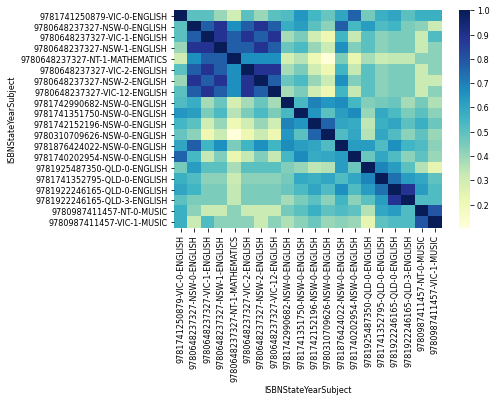

In [185]:
# plot the similarity matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

subset_df = similarity_df.iloc[0:20, 0:20]  # Extracting a 10x10 subset
sns.heatmap(subset_df, cmap="YlGnBu")
plt.show()



In [178]:


# copy df_enrichedBooks to a new dataframe called df_lookup
df_lookup = df_enrichedBooksWork.copy()

# function to try combinations of userBookISBN, userBookState, userBookYear and userBookSubject until a match is found in the similarity_df dataframe
def getSimilarityMatrixKey(BookISBN, BookState, BookYear, BookSubject):
     return  BookISBN+"-"+BookState+"-"+BookYear+"-"+BookSubject

# function to replace the recommended booms with the same ISBN as the userBookISBN
# and replace any duplicate ISBNs in the list of recommended books
# This happens because in this recommender suystems the columns and rows in the similatity
# matrix are the ISBN+State+Year+Subject combinations and not just the ISBN
def replaceSameISBN(books, userBookISBN):
     # create a new list to hold the ISBNs of the books
     booksISBN = []
     # for each book in the list of books
     for book in books:
           # add the ISBN to the list of ISBNs
           booksISBN.append(book.split('-')[0])
     # remove the userBookISBN from the list of ISBNs
     if userBookISBN in booksISBN:
          booksISBN.remove(userBookISBN)
     # remove any duplicate ISBNs from the list of ISBNs
     booksISBN = list(dict.fromkeys(booksISBN))
     return booksISBN # clean set of ISBNs


def printRecommendations(books):
    # for each book in the list of books
    for book in books:
        #currentISBN=int(book.split('-')[0])
        currentISBN=book
        # print the book details
        print("Recommended ISBN: "+currentISBN)
        print("Title: "+df_lookup[df_lookup['ISBN'] == int(currentISBN)]['title'].iloc[0])
        print("Description: "+df_lookup[df_lookup['ISBN'] == int(currentISBN)]['description'].iloc[0])
        print("------------")

#userBookISBN = "9781741250879"
#userBookState = "VIC"
#userBookYear = "0"
#userBookSubject = "ENGLISH"


userBookISBN = "9780521698986"
userBookState = "QLD"
userBookYear = "12"
userBookSubject = "LEGAL STUDIES"

userBookISBNStateYearSubject=getSimilarityMatrixKey(userBookISBN, userBookState, userBookYear, userBookSubject)

# make sure we get 5 reccomendations with unique ISBN, 
# this is needed because the ISBN+State+Year+Subject combination
# not just the ISBN is used to find the most similar books
#clear the list of recommended books
requiredRecommendations=5  # the maximum number of recommended books
recommendedCount=0
while recommendedCount<5:
     topBooks = similarity_df[userBookISBNStateYearSubject].sort_values(ascending=False)[1:requiredRecommendations+1]
     booklist = topBooks.index.tolist()
     topBooks=replaceSameISBN(booklist, userBookISBN)
     recommendedCount=len(topBooks)
     # increment the maxRecommendedCount by 1
     requiredRecommendations=requiredRecommendations+1
     # break id the maxRecommendedCount is greater than 10
     # avoid infinate loop - give up after 10 attempts
     if requiredRecommendations>10:
          break

print(topBooks)

print("Based on the ISBN: "+userBookISBN)
print("Title: "+df_lookup[df_lookup['ISBN'] == int(userBookISBN)]['title'].iloc[0])
print("Description: "+df_lookup[df_lookup['ISBN'] == int(userBookISBN)]['description'].iloc[0])
print("\nThe recommended books are listed below:")

printRecommendations(topBooks)




['9781108469500', '9781876734947', '9781108797542', '9780190312145', '9780190310325']
Based on the ISBN: 9780521698986
Title: LEGAL STUDIES
Description: legal studi

The recommended books are listed below:
Recommended ISBN: 9781108469500
Title: LEGAL STUDIES
Description: legal studi
------------
Recommended ISBN: 9781876734947
Title: Legal Studies: SACE stage 1
Description: legal studi sace stage
------------
Recommended ISBN: 9781108797542
Title: Cambridge Legal Studies: Stage 6 Year 12 Fifth Edition
Description: cambridg legal studi stage fifth edit
------------
Recommended ISBN: 9780190312145
Title: LEGAL STUDIES
Description: legal studi
------------
Recommended ISBN: 9780190310325
Title: LEGAL STUDIES
Description: legal studi
------------


Now we need to dop some more rigourus testing.  One approach to do this can be based on checking to see how many of the recommended books are actually being used by real schools for that subject at that year level. 

A recommender system may be tested by users using A/B testing: A/B testing involves randomly assigning users to two groups: one that receives recommendations from this content-based recommender system and one that receives recommendations from a different system (or no recommendations at all). How well each group responds to the recommendations can be compared.  (Neptune.ai. 2022)

A more rigorous approach involves:

Calculate precision: Precision is the number of relevant items recommended by your system divided by the total number of items recommended by your system. To calculate precision, you need to know which items are relevant to the user. You can do this by creating a test set of items that the user has already rated or interacted with in some way. Then, you can compare the items in your test set to the items recommended by your system and calculate precision.

Calculate recall: Recall is the number of relevant items recommended by your system divided by the total number of relevant items in your test set. To calculate recall, you need to know which items are relevant to the user. You can do this by creating a test set of items that the user has already rated or interacted with in some way. Then, you can compare the items in your test set to the items recommended by your system and calculate recall.


NOTE:  I don't have sufficient time to implement this approach hopweve some thinking around how I might be able to do it is as follows:

For each BookISBNStateYearSubject get recommendations
    # Precision (i) identify the relevant items as those that are actually used by a school for that subject at around the same year level   (ii) number of resposes that are "relevant" / number or returned responses   is Precision
    # Recall (i) Total number of relevant items that are recommended by the syustem (as determined by above method) divide by the total relavant items in the data